In [1]:
import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml
import os
import re
import json

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from IPython.display import JSON
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sapsam import parser, constants, detector, filters
from sapsam.filters import DataFilter

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [3]:
# mappings for namespaces and element types
with open(constants.SRC_ROOT / 'mappings.json') as json_file:
    mappings = json.load(json_file)

# Read Data

Let's first read in the meta data of all models in the dataset.

In [4]:
df_meta = parser.parse_model_metadata()
df_meta.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.24it/s]


revision_id  \
model_id                                                             
0c4a4701a6524166adaab25fb9e06374  24280a31d8a045aebdbd69b996a848b7   
0c4a6cb2013d488e811de3cca728d5b6  e839d9d1b7244acd8324ff4b05b4cf57   
0c4a6e19f392466c9f5ea34f0753397d  cb8a1351a515467b822fae0cf0b527df   
0c4a78ebe86f48aaa7860059c2c117db  a82d4aba3c5d40d39181aab57fe6c368   
0c4a80580f0143c691ea5bbbb1f42ba1  188fc2f3e52b429bbda22f12bfb01edc   

                                                   organization_id  \
model_id                                                             
0c4a4701a6524166adaab25fb9e06374  c41660388a04449a995dccf97d894f46   
0c4a6cb2013d488e811de3cca728d5b6  54bfa7a85e5741878102658795743f3a   
0c4a6e19f392466c9f5ea34f0753397d  ea6228bbe6f14163a04b3d115bae768b   
0c4a78ebe86f48aaa7860059c2c117db  53efc177fa0a4e98af2fd3bf7be18470   
0c4a80580f0143c691ea5bbbb1f42ba1  a54008f9eb7b45129caa83592542548a   

                                             datetime description  \
model_id                                                            
0c4a4701a6524166adaab25fb9e06374  2021-08-14 17:19:56         NaN   
0c4a6cb2013d488e811de3cca728d5b6  2021-02-11 12:36:57         NaN   
0c4a6e19f392466c9f5ea34f0753397d  2021-04-03 17:01:03         NaN   
0c4a78ebe86f48aaa7860059c2c117db  2019-06-06 11:09:06         NaN   
0c4a80580f0143c691ea5bbbb1f42ba1  2017-07-02 19:11:17         NaN   

                                                                           name  \
model_id                                                                          
0c4a4701a6524166adaab25fb9e06374                                       12345678   
0c4a6cb2013d488e811de3cca728d5b6  Lösung zu Übung 1 BKMs Finanzierungsvergleich   
0c4a6e19f392466c9f5ea34f0753397d                                      homework1   
0c4a78ebe86f48aaa7860059c2c117db                         Mitarbeiter Onboarding   
0c4a80580f0143c691ea5bbbb1f42ba1   Jane Doe:Unterprozess:Auszahlung veranlassen   

                                 type  \
model_id                                
0c4a4701a6524166adaab25fb9e06374  NaN   
0c4a6cb2013d488e811de3cca728d5b6  NaN   
0c4a6e19f392466c9f5ea34f0753397d  NaN   
0c4a78ebe86f48aaa7860059c2c117db  NaN   
0c4a80580f0143c691ea5bbbb1f42ba1  NaN   

                                                                 namespace  
model_id                                                                    
0c4a4701a6524166adaab25fb9e06374       http://b3mn.org/stencilset/bpmn2.0#  
0c4a6cb2013d488e811de3cca728d5b6  http://signavio.com/stencilsets/dmn-1.0#  
0c4a6e19f392466c9f5ea34f0753397d       http://b3mn.org/stencilset/bpmn2.0#  
0c4a78ebe86f48aaa7860059c2c117db       http://b3mn.org/stencilset/bpmn2.0#  
0c4a80580f0143c691ea5bbbb1f42ba1       http://b3mn.org/stencilset/bpmn2.0#

# Filtering example processes

The dataset includes the following vendor provided example processes.

In [5]:
len(df_meta)

11471

In [6]:
#df_meta = DataFilter(df_meta)
#df_meta = df_meta.filter_data("example_processes")
len(df_meta)

11471

In [7]:
import json
with open(constants.SRC_ROOT / "prefilled_example_processes.json") as data_file:    
    examples = json.load(data_file)

Here is the list of all example processes names:

In [8]:
example_names = []
for batch in examples["example_processes"]:
    example_names.extend(batch["content"])
example_names = set(example_names)
example_names

{'Arbeitsmittel beschaffen',
 'BANF-zu-Bestellung',
 'Bestellung-zu-Lieferung',
 'Bewerber prüfen',
 'Bewerbungseingang',
 'Check quantity and quality',
 'Commande de pièces',
 'Contrôler la quantité et la qualité',
 'Delivery-to-Payment',
 "Donner l'équipement de travail",
 'Ebene  2 - Prozessbereich: Personalwesen',
 'Ebene 1 - Prozesslandkarte ACME AG',
 'Ebene 2 - Prozessbereich: Auftragsdurchführung',
 'Ebene 2 - Prozessbereich: Produktentwicklung',
 'Employee Onboarding',
 "Installation d'un employé",
 'Level  2 - Process Area: Human Resources',
 'Level 1 - Value Chain ACME AG',
 'Level 2 - Process Area: Order Processing',
 'Level 2 - Process Area: Product Development',
 'Lieferung-zu-Bezahlung',
 'Menge und Qualität überprüfen',
 'Mitarbeiter Onboarding',
 "Niveau 1 – Chaine de valeur d'ACME AG",
 'Niveau 2 - Processus de développement produit',
 'Niveau 2 - Processus de gestion des commandes',
 'Niveau 2 - Processus des Ressources Humaines',
 'Procure parts',
 'Procurement of W

Now let's take a look at the number of examples processes in the dataset (note that we decide this based on the process name which is more of a rough estimate rather than an accurate number):

In [9]:
df_meta_examples = df_meta[df_meta["name"].isin(example_names)]
len(df_meta_examples)

5317

This is the percentage of example process from the dataset:

In [10]:
len(df_meta_examples)/len(df_meta)

0.4635166942725133

This is the number of models in the dataset without example processes (again, based on process names):

In [11]:
len(df_meta)-len(df_meta_examples)

6154

And the percentage of models in the dataset without example processes:

In [12]:
(len(df_meta)-len(df_meta_examples))/len(df_meta)

0.5364833057274867

We apply the filter to perform the analysis on the dataset without examples processes:

In [13]:
df_meta = DataFilter(df_meta)
df_meta = df_meta.filter_data("example_processes")
len(df_meta)

6154

We see that the size of the dataset now matches the previous calculation of the number of models without example processes.

# Modeling notations

We want to examine the usage of modeling notations in the dataset.

Let's start with counting the number of models in different modeling notations.

In [14]:
df_notations = pd.DataFrame.from_dict(dict(Counter(df_meta["namespace"])),orient = "index")
df_notations.reset_index(inplace=True)
df_notations.columns = ["Notation","Frequency"]
df_notations.sort_values(by=['Frequency'], ascending=False, inplace=True, ignore_index=True)
df_notations

Notation  Frequency
0                 http://b3mn.org/stencilset/bpmn2.0#       4531
1                     http://b3mn.org/stencilset/epc#        357
2     http://www.signavio.com/stencilsets/processmap#        228
3             http://b3mn.org/stencilset/UML2.2Class#        195
4                 http://b3mn.org/stencilset/bpmn1.1#        166
5                http://b3mn.org/stencilset/petrinet#        135
6            http://signavio.com/stencilsets/dmn-1.0#        132
7              http://b3mn.org/stencilset/UMLUseCase#        123
8          http://cisco.com/stencilset/archimate-2.1#        120
9     http://www.signavio.com/stencilsets/organigram#         55
10    http://b3mn.org/stencilset/bpmn2.0choreography#         46
11    http://b3mn.org/stencilset/bpmn2.0conversation#         29
12  http://www.fmc-modeling.org/stencilsets/fmcblo...         11
13    http://www.signavio.com/stencilsets/journeymap#          7
14                http://b3mn.org/stencilset/yawl2.2#          6
15        http://b3mn.org/stencilset/coloredpetrinet#          5
16          http://signavio.com/stencilsets/cmmn-1.0#          5
17  http://www.signavio.com/stencilsets/processdoc...          3

We map the namespaces to the common names for the modeling notations.

In [15]:
d_namespaces = mappings["namespaces"]
d_namespaces_reverse = {}
for k,v in d_namespaces.items():
    d_namespaces_reverse[v]=k
df_notations = df_notations.replace({'Notation' : d_namespaces})
df_notations

Notation  Frequency
0                         BPMN 2.0       4531
1                              EPC        357
2                      Value Chain        228
3                    UML 2.2 Class        195
4                         BPMN 1.1        166
5                        Petri Net        135
6                          DMN 1.0        132
7                     UML Use Case        123
8                    ArchiMate 2.1        120
9                       Organigram         55
10           BPMN 2.0 Choreography         46
11           BPMN 2.0 Conversation         29
12               FMC Block Diagram         11
13                     Journey Map          7
14                        YAWL 2.2          6
15                             CPN          5
16                        CMMN 1.0          5
17  Process Documentation Template          3

Now, we have the option to filter the data for the analysis.

In this case, the filter takes between **1** and **3** arguments, where "namespaces" is the filter type.

The **2nd** argument can be an integer, a notation name, or "max". It indicates the number of individual notations that should be kept in the filtered dataset, by descending frequency. The actual notation name can be used, if all others notations should be removed from the dataset.

The **3rd** argument is optional and represents a frequency threshold, under which the corresponding notations will be aggregated into a subgroup "Other".

For example, let's aggregate modeling notations which are used for less than 100 models in "Other".

In [16]:
df_notations = DataFilter(df_notations)
df_notations = df_notations.filter_data("namespaces", "max", 100)
df_notations

Notation  Frequency
0       BPMN 2.0       4531
1            EPC        357
2    Value Chain        228
3  UML 2.2 Class        195
4          Other        167
5       BPMN 1.1        166
6      Petri Net        135
7        DMN 1.0        132
8   UML Use Case        123
9  ArchiMate 2.1        120

We can visualise the number of models in different modeling notations.

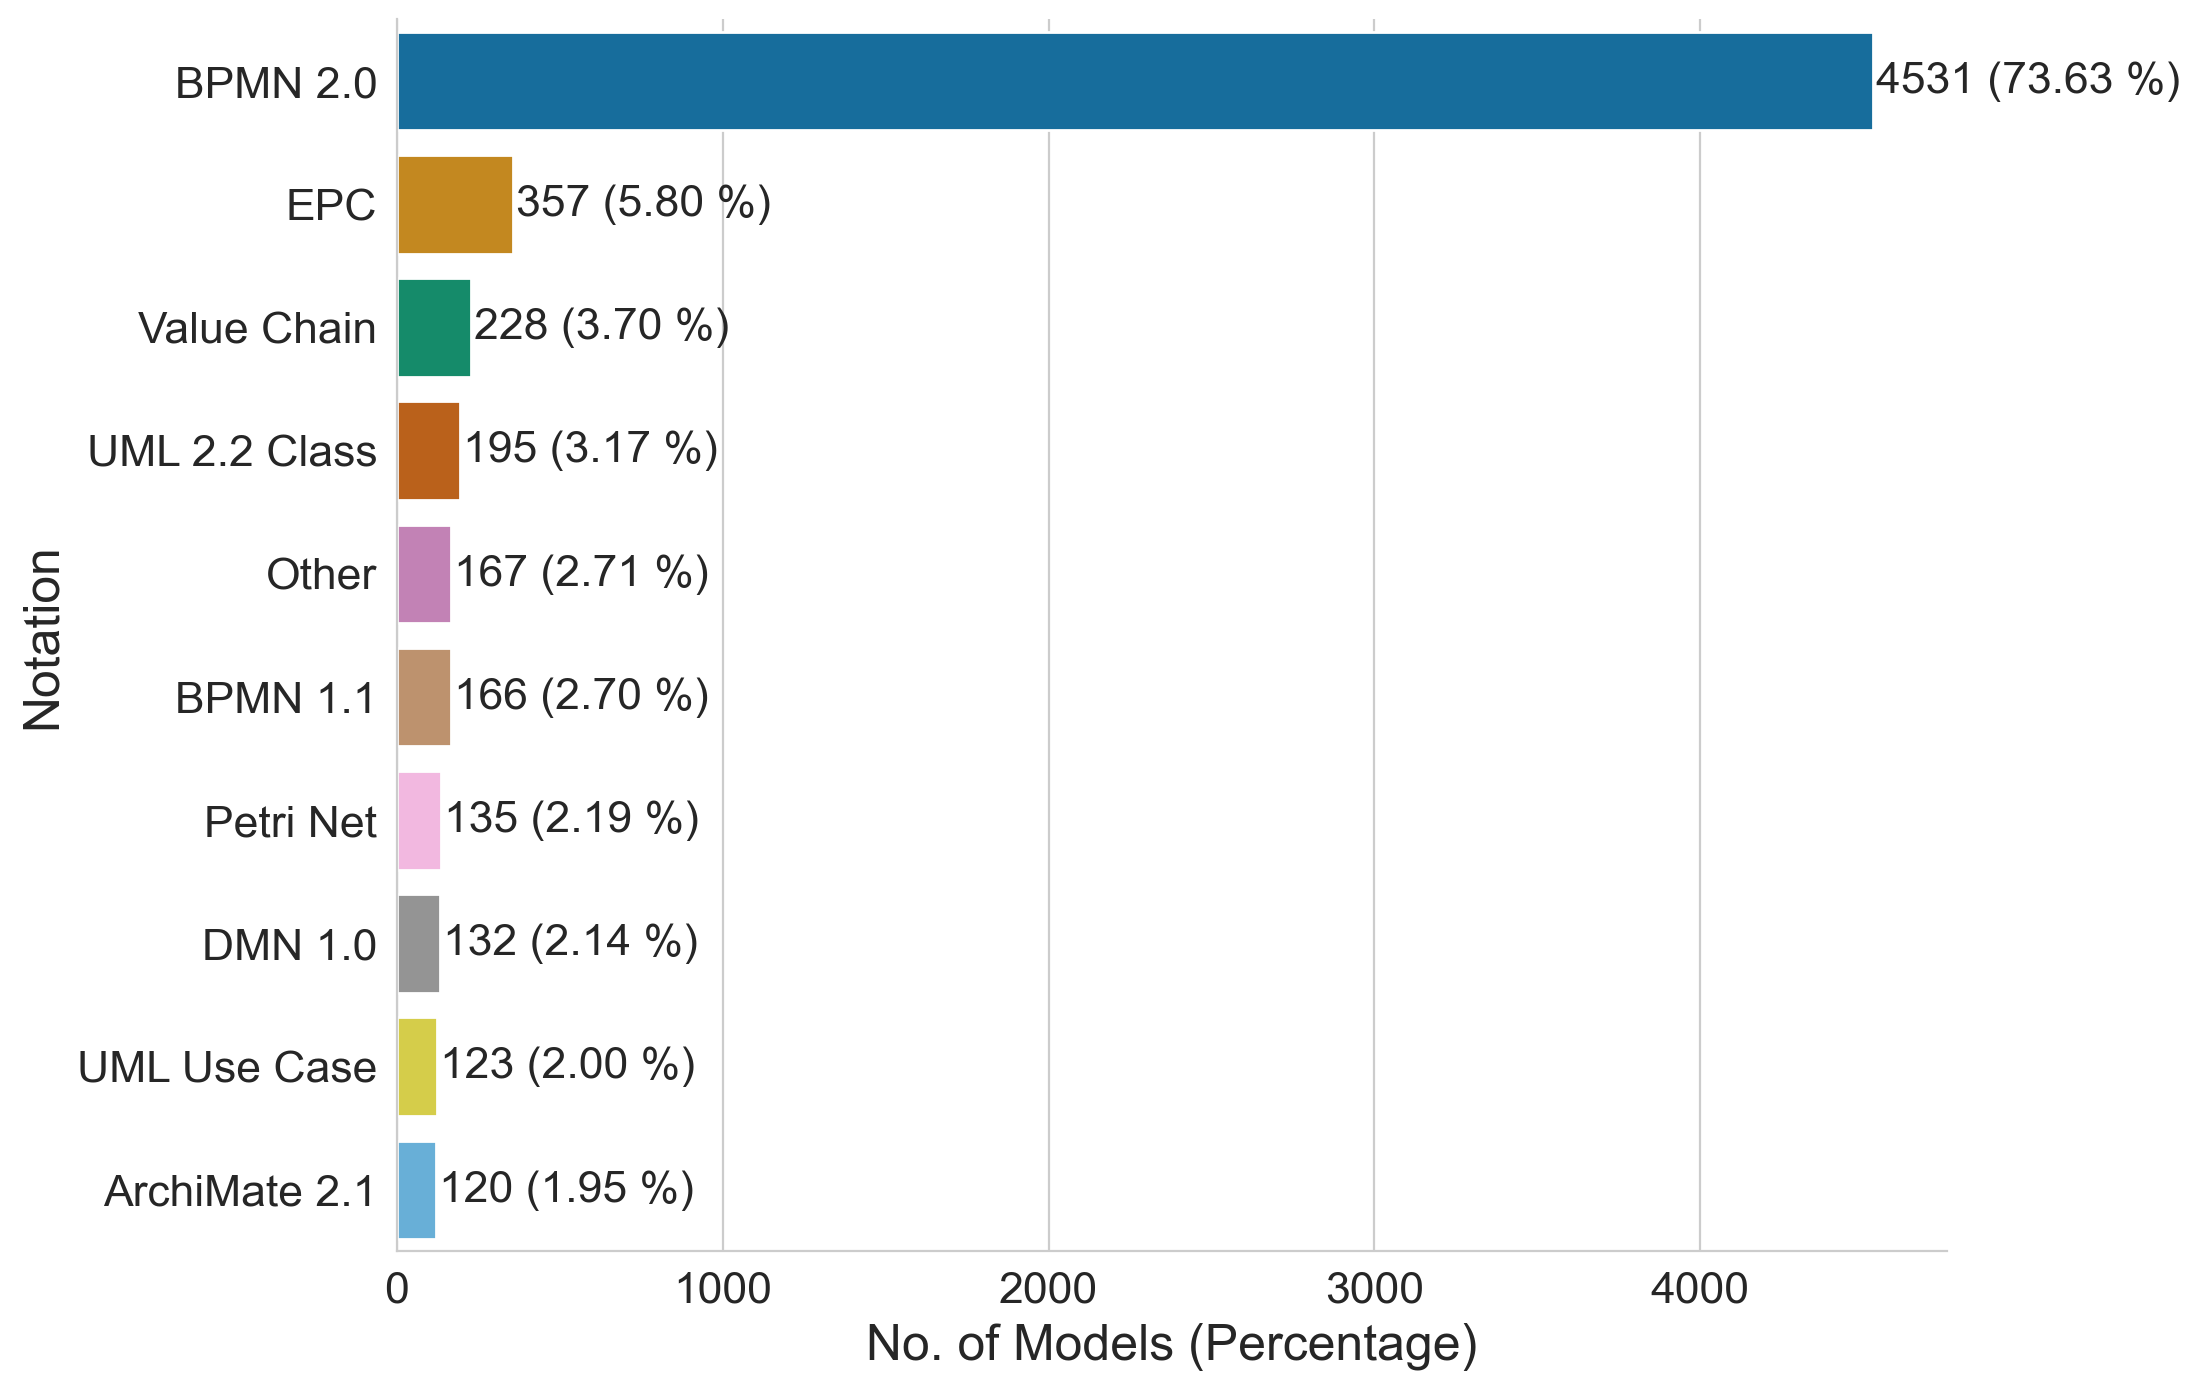

In [17]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
ax=sns.barplot(x="Frequency", y="Notation", data=df_notations, estimator = np.max,ci = 0, palette = sns.color_palette("colorblind"))
# ax=sns.barplot(x="Frequency", y="Notation", hue="Notation", data=df_notations, estimator = np.max, errorbar=('ci', 0), legend=False)
sns.despine()
ax.bar_label(ax.containers[0], label_type='edge', padding=1, labels=[f'{val} ({val/ len(df_meta) * 100.0:.2f} %)' for val in df_notations["Frequency"]])
ax.set_xlabel('No. of Models (Percentage)', fontsize=18)
ax.set_ylabel('Notation', fontsize=18)
# ax.set_xlim(0,700000)
plt.savefig(constants.FIGURES_ROOT / 'notations.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

By using the datetime column, we can also consider the creation of models in different notations over time.

In [18]:
df_meta.datetime = pd.to_datetime(df_meta.datetime)

These are the first and the last created models in the dataset:

In [19]:
df_meta.sort_values('datetime').head(1)

revision_id  \
model_id                                                             
c1f9781d06594f068bee14f96d6744f3  43fe80a91c114d3ca121e8e8fb03a0a6   

                                                   organization_id  \
model_id                                                             
c1f9781d06594f068bee14f96d6744f3  c78f482cc9d54a278154a3d1671450db   

                                            datetime description  \
model_id                                                           
c1f9781d06594f068bee14f96d6744f3 2011-12-01 23:11:10         NaN   

                                              name       type  \
model_id                                                        
c1f9781d06594f068bee14f96d6744f3  Ampel - Lösung 1  Petrinets   

                                                             namespace  
model_id                                                                
c1f9781d06594f068bee14f96d6744f3  http://b3mn.org/stencilset/petrinet#

In [20]:
df_meta.sort_values('datetime').tail(1)

revision_id  \
model_id                                                             
c32c4d43c1a3473d8db670c3739bbb97  b72919cca2154cb5aba499254e0bd2b1   

                                                   organization_id  \
model_id                                                             
c32c4d43c1a3473d8db670c3739bbb97  8f45cdba3d7c4c1b814f1ab1a883e289   

                                            datetime description  \
model_id                                                           
c32c4d43c1a3473d8db670c3739bbb97 2021-09-22 02:56:10         NaN   

                                            name type  \
model_id                                                
c32c4d43c1a3473d8db670c3739bbb97  LABORATORIO 6B  NaN   

                                                            namespace  
model_id                                                               
c32c4d43c1a3473d8db670c3739bbb97  http://b3mn.org/stencilset/bpmn2.0#

Let's check the creation of models over time for the five most used notations. We leave the "Other" subgroup out.

In [21]:
df_notations = DataFilter(df_notations)
selected_notations = df_notations.filter_data("namespaces", 5)
selected_notations['Notation'] = selected_notations['Notation'].map(d_namespaces_reverse)
selected_notations

Notation  Frequency
0              http://b3mn.org/stencilset/bpmn2.0#       4531
1                  http://b3mn.org/stencilset/epc#        357
2  http://www.signavio.com/stencilsets/processmap#        228
3          http://b3mn.org/stencilset/UML2.2Class#        195
4              http://b3mn.org/stencilset/bpmn1.1#        166

In [22]:
df_meta_selected = df_meta[df_meta.namespace.isin(selected_notations['Notation'])].copy()
df_meta_selected['Count']= 1
df_meta_selected=df_meta_selected[['datetime','Count','namespace']].sort_values('datetime')
df_meta_selected.set_index('datetime', inplace=True)

We count the number of models created per year.

In [23]:
df_meta_selected = df_meta_selected.groupby('namespace').resample('Y').sum().reset_index()
df_meta_selected['Year'] = df_meta_selected['datetime'].apply(lambda x:x.year)

To ensure index consistency in the plot, we pivot the table and fill the count for missing years with 0. This step is a precaution for the case when a notation hasn't been created for a given year.

In [24]:
df_meta_selected = df_meta_selected.pivot_table(index='Year', columns='namespace', values='Count', fill_value=0)
df_meta_selected = df_meta_selected.reset_index().melt(var_name='namespace', value_name='Count', id_vars='Year')
df_meta_selected = df_meta_selected[['namespace', 'Count', 'Year']]

df_meta_selected = df_meta_selected.replace({'namespace' : d_namespaces})
df_meta_selected

namespace  Count  Year
0   UML 2.2 Class      2  2015
1   UML 2.2 Class     18  2016
2   UML 2.2 Class     22  2017
3   UML 2.2 Class     24  2018
4   UML 2.2 Class     11  2019
5   UML 2.2 Class     55  2020
6   UML 2.2 Class     63  2021
7        BPMN 1.1      3  2015
8        BPMN 1.1      7  2016
9        BPMN 1.1     14  2017
10       BPMN 1.1     25  2018
11       BPMN 1.1     18  2019
12       BPMN 1.1     36  2020
13       BPMN 1.1     63  2021
14       BPMN 2.0     52  2015
15       BPMN 2.0    205  2016
16       BPMN 2.0    442  2017
17       BPMN 2.0    727  2018
18       BPMN 2.0    943  2019
19       BPMN 2.0   1036  2020
20       BPMN 2.0   1126  2021
21            EPC     13  2015
22            EPC     31  2016
23            EPC     60  2017
24            EPC     74  2018
25            EPC     62  2019
26            EPC     76  2020
27            EPC     41  2021
28    Value Chain      2  2015
29    Value Chain     14  2016
30    Value Chain     23  2017
31    Value Chain     40  2018
32    Value Chain     46  2019
33    Value Chain     66  2020
34    Value Chain     37  2021

Since the number of models created before 2015 in the dataset is rather small, we visualize the numbers starting in 2015. Also, the dataset only contains models until September 2021, so we exclude 2021, too.

In [25]:
sum(df_meta['datetime'].apply(lambda x: x.year)<2015)

1

In [26]:
df_meta_selected=df_meta_selected[df_meta_selected['Year']>=2015]
df_meta_selected=df_meta_selected[df_meta_selected['Year']<2021]
df_meta_selected.head()

namespace  Count  Year
0  UML 2.2 Class      2  2015
1  UML 2.2 Class     18  2016
2  UML 2.2 Class     22  2017
3  UML 2.2 Class     24  2018
4  UML 2.2 Class     11  2019

In [27]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 2000x1000 with 0 Axes>

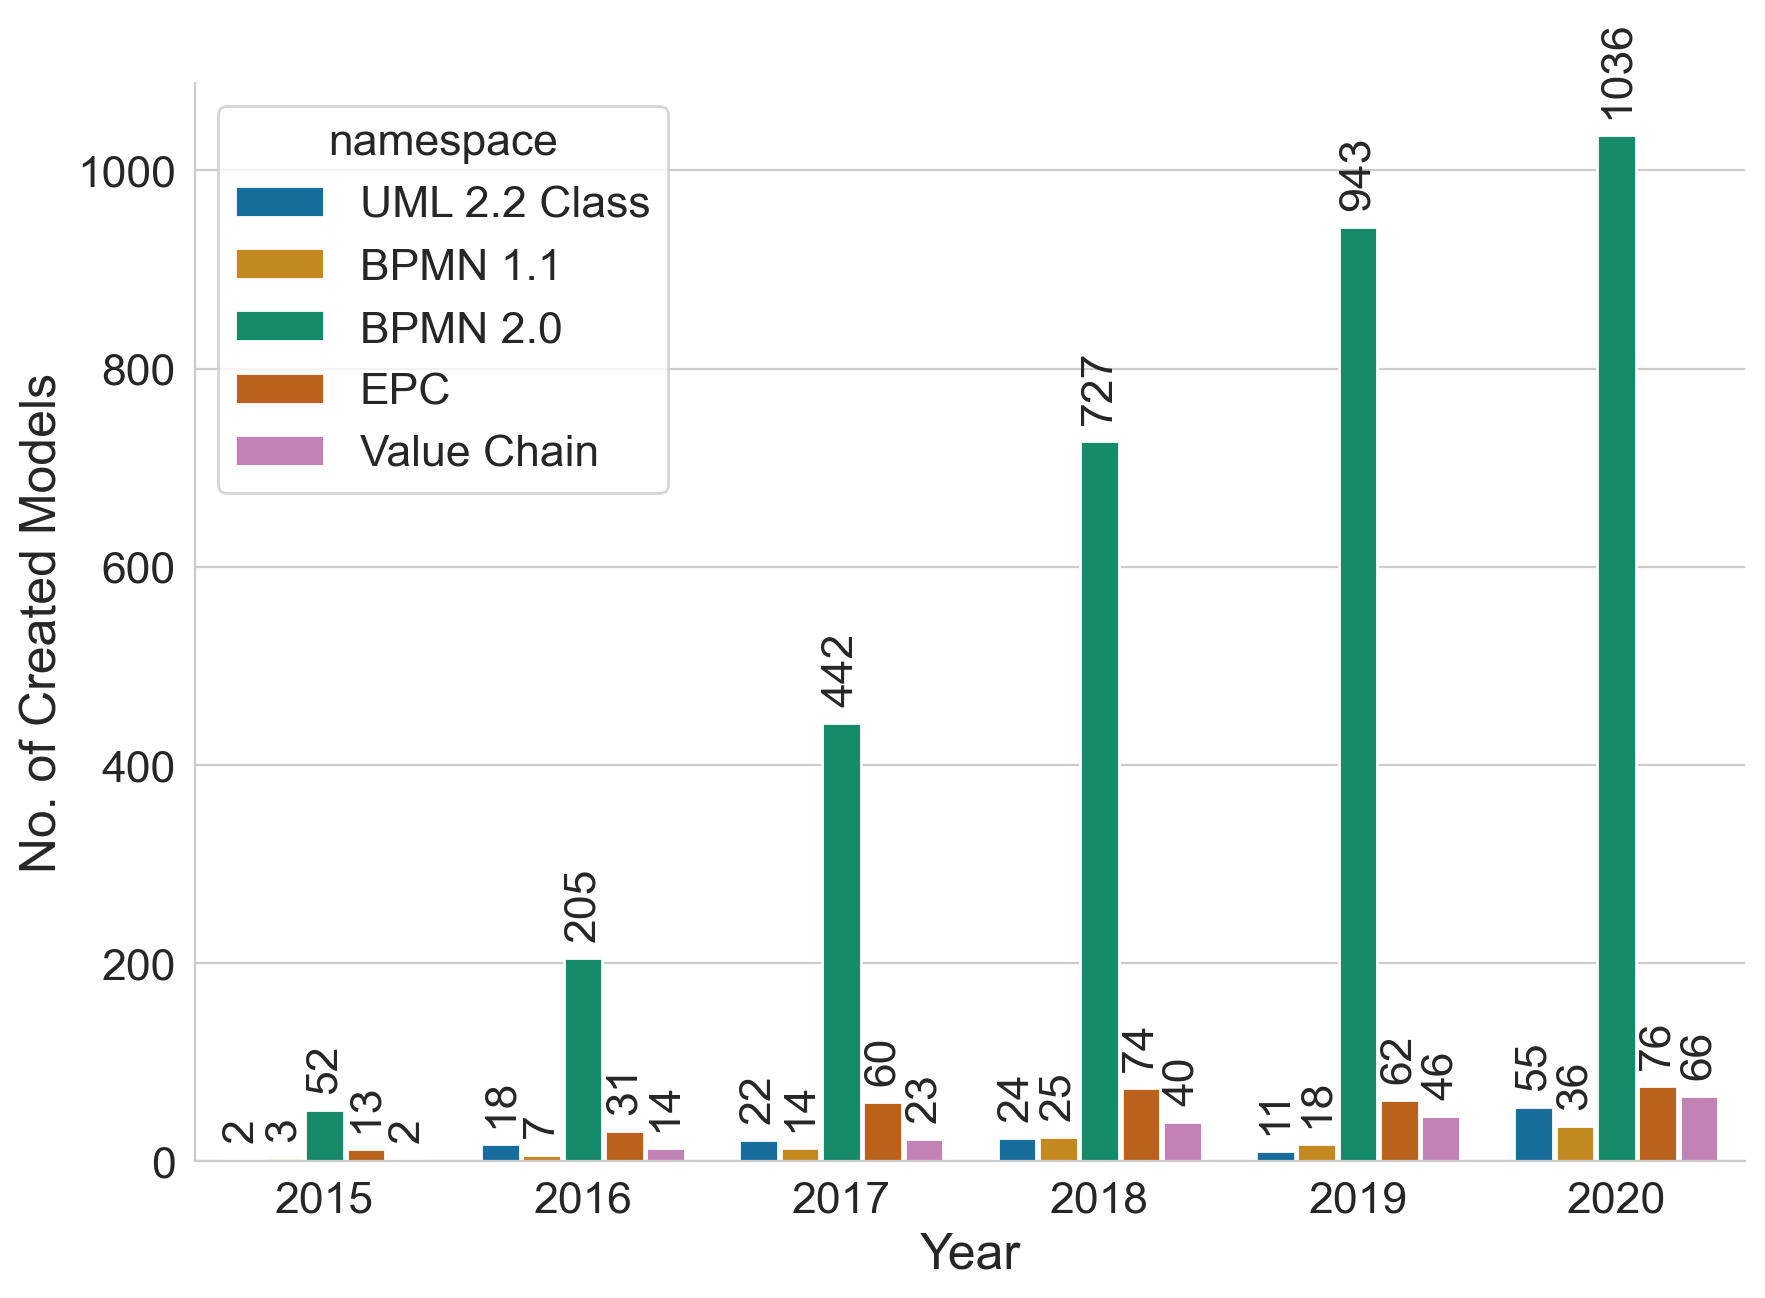

In [28]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_meta_selected,x='Year', y='Count', hue='namespace',ax=ax,palette=sns.color_palette("colorblind"))
#plt.legend(title='', loc='upper left')
change_width(ax, .15)
for container in ax.containers:
    ax.bar_label(container, padding = 6, rotation='vertical')
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('No. of Created Models',fontsize=18)
sns.despine()

We can also visualize this as stacked plot.

In [29]:
selected_notations_short = [d_namespaces[n] for n in selected_notations['Notation']]
d_stacked = dict()
for n in selected_notations_short:
    d_stacked[n] = df_meta_selected[df_meta_selected["namespace"]==n]["Count"].values
df_stacked = pd.DataFrame(d_stacked, index=df_meta_selected.Year.unique())
df_stacked.sort_index(ascending=False,inplace=True)
df_stacked

BPMN 2.0  EPC  Value Chain  UML 2.2 Class  BPMN 1.1
2020      1036   76           66             55        36
2019       943   62           46             11        18
2018       727   74           40             24        25
2017       442   60           23             22        14
2016       205   31           14             18         7
2015        52   13            2              2         3

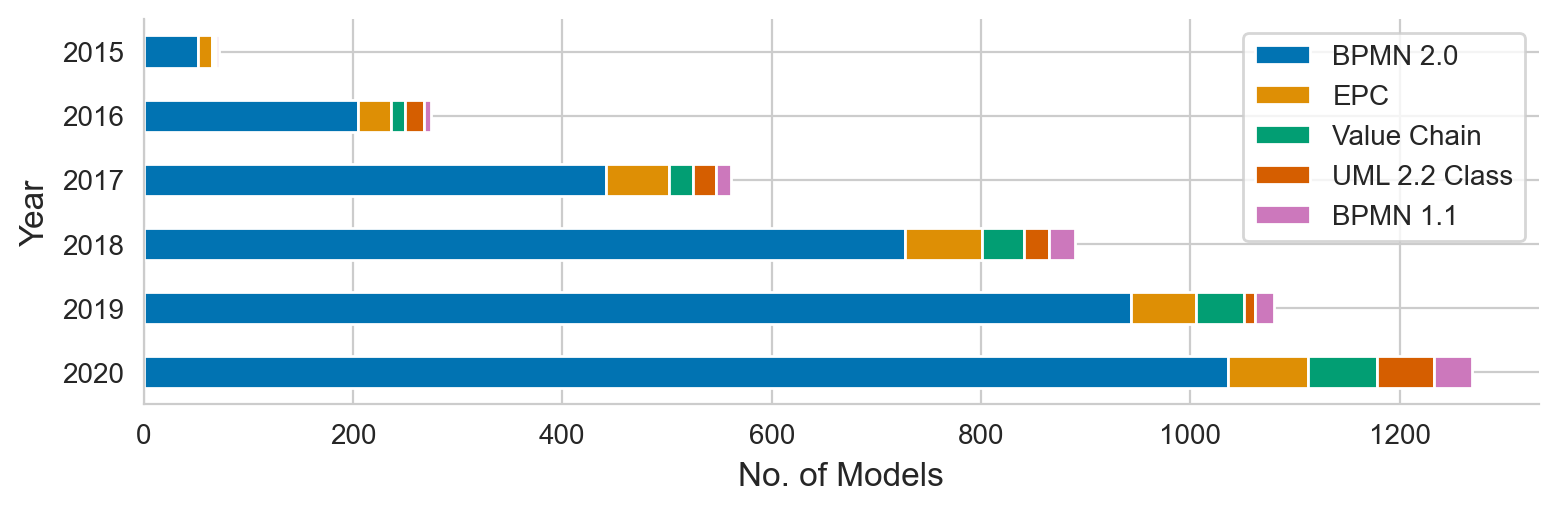

In [30]:
plt.rcParams.update({'font.size': 10})
ax = df_stacked.plot(kind='barh', stacked=True,figsize=(9,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("No. of Models",fontsize=12)
ax.set_ylabel("Year",fontsize=12)
plt.savefig(constants.FIGURES_ROOT / 'notations_over_time.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Parse BPMN 2.0 models

For further analysis, we concentrate on BPMN 2.0 models as primary used notation.

In [31]:
df_meta_bpmn = df_meta[df_meta.namespace == constants.BPMN2_NAMESPACE]
df_meta_bpmn.head()

revision_id  \
model_id                                                             
0c4a4701a6524166adaab25fb9e06374  24280a31d8a045aebdbd69b996a848b7   
0c4a6e19f392466c9f5ea34f0753397d  cb8a1351a515467b822fae0cf0b527df   
0c4a80580f0143c691ea5bbbb1f42ba1  188fc2f3e52b429bbda22f12bfb01edc   
0c4a8a87a5074bf0ac488fb15d9ff828  8c20371e944b4833a3176257acf0c0f4   
0c4aa1c91ff9451d89c2a6f69632e2ff  b1bf293fe4bd40d491f1e9096a1c8b4f   

                                                   organization_id  \
model_id                                                             
0c4a4701a6524166adaab25fb9e06374  c41660388a04449a995dccf97d894f46   
0c4a6e19f392466c9f5ea34f0753397d  ea6228bbe6f14163a04b3d115bae768b   
0c4a80580f0143c691ea5bbbb1f42ba1  a54008f9eb7b45129caa83592542548a   
0c4a8a87a5074bf0ac488fb15d9ff828  91ad7bac45a2491bb32721669ad5790a   
0c4aa1c91ff9451d89c2a6f69632e2ff  cbc6a3654f3649a2b05410f0ffabda2c   

                                            datetime description  \
model_id                                                           
0c4a4701a6524166adaab25fb9e06374 2021-08-14 17:19:56         NaN   
0c4a6e19f392466c9f5ea34f0753397d 2021-04-03 17:01:03         NaN   
0c4a80580f0143c691ea5bbbb1f42ba1 2017-07-02 19:11:17         NaN   
0c4a8a87a5074bf0ac488fb15d9ff828 2019-11-27 19:58:35         NaN   
0c4aa1c91ff9451d89c2a6f69632e2ff 2020-05-02 15:43:04         NaN   

                                                                          name  \
model_id                                                                         
0c4a4701a6524166adaab25fb9e06374                                      12345678   
0c4a6e19f392466c9f5ea34f0753397d                                     homework1   
0c4a80580f0143c691ea5bbbb1f42ba1  Jane Doe:Unterprozess:Auszahlung veranlassen   
0c4a8a87a5074bf0ac488fb15d9ff828                             Aufgabe4_Jane Doe   
0c4aa1c91ff9451d89c2a6f69632e2ff                           A1.2-2 - CORRECTION   

                                      type  \
model_id                                     
0c4a4701a6524166adaab25fb9e06374       NaN   
0c4a6e19f392466c9f5ea34f0753397d       NaN   
0c4a80580f0143c691ea5bbbb1f42ba1       NaN   
0c4a8a87a5074bf0ac488fb15d9ff828       NaN   
0c4aa1c91ff9451d89c2a6f69632e2ff  BPMN 2.0   

                                                            namespace  
model_id                                                               
0c4a4701a6524166adaab25fb9e06374  http://b3mn.org/stencilset/bpmn2.0#  
0c4a6e19f392466c9f5ea34f0753397d  http://b3mn.org/stencilset/bpmn2.0#  
0c4a80580f0143c691ea5bbbb1f42ba1  http://b3mn.org/stencilset/bpmn2.0#  
0c4a8a87a5074bf0ac488fb15d9ff828  http://b3mn.org/stencilset/bpmn2.0#  
0c4aa1c91ff9451d89c2a6f69632e2ff  http://b3mn.org/stencilset/bpmn2.0#

Number of BPMN 2.0 models:

In [32]:
len(df_meta_bpmn)

4531

We use the BPMNModelParser to parse the BPMN 2.0 models. In case, we have already parsed them, we load the parsed data from the pkl file.

In [33]:
p = parser.BpmnModelParser() # comment this line if you have already created the pkl file
df_bpmn = p.parse_model_elements() # comment this line if you have already created the pkl file
df_bpmn.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # comment this line if you have already created the pkl file
# df_bpmn = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # uncomment this line if you have already created the pkl file
df_bpmn.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.65s/it]


category  \
model_id                         element_id                                                             
0c4a4701a6524166adaab25fb9e06374 sid-E204B1EC-9C87-4D00-BD05-99E3C0E16451      Association_Undirected   
                                 sid-95792EAA-4CD5-420C-8CE2-39A5FA0D754B                  DataObject   
                                 sid-C744BE2D-16E8-4E01-9AFD-C3231949A6F6                 MessageFlow   
                                 sid-E02A705D-61A3-4780-A5F2-9A29F04A106A      Association_Undirected   
                                 sid-ACE07FA0-72ED-4199-914F-52D991AC9C78  Association_Unidirectional   

                                                                          label  \
model_id                         element_id                                       
0c4a4701a6524166adaab25fb9e06374 sid-E204B1EC-9C87-4D00-BD05-99E3C0E16451  None   
                                 sid-95792EAA-4CD5-420C-8CE2-39A5FA0D754B    AE   
                                 sid-C744BE2D-16E8-4E01-9AFD-C3231949A6F6         
                                 sid-E02A705D-61A3-4780-A5F2-9A29F04A106A  None   
                                 sid-ACE07FA0-72ED-4199-914F-52D991AC9C78  None   

                                                                               name  
model_id                         element_id                                          
0c4a4701a6524166adaab25fb9e06374 sid-E204B1EC-9C87-4D00-BD05-99E3C0E16451  12345678  
                                 sid-95792EAA-4CD5-420C-8CE2-39A5FA0D754B  12345678  
                                 sid-C744BE2D-16E8-4E01-9AFD-C3231949A6F6  12345678  
                                 sid-E02A705D-61A3-4780-A5F2-9A29F04A106A  12345678  
                                 sid-ACE07FA0-72ED-4199-914F-52D991AC9C78  12345678

Number of BPMN 2.0 models from the parser:

In [34]:
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

6819

Number of BPMN 2.0 models from the parser after filtering out example processes:

In [35]:
df_bpmn = DataFilter(df_bpmn)
df_bpmn = df_bpmn.filter_data("example_processes")
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

4386

When compared to the analysis of the dataset metadata, we notice the count of BPMN 2.0 models is slightly lower. This difference shows that there are some empty BPMN 2.0 models in the dataset which do not contain any elements, and thus ignored during the parsing.

In [36]:
#model_id_counts = df_bpmn.groupby(level='model_id').size()
#print(model_id_counts.loc[model_id_counts.idxmin()])
#print(model_id_counts.idxmin())

The total number of elements of all BPMN 2.0 models is:

In [37]:
len(df_bpmn)

219571

# Languages

We use spaCy to detect the language of a model. More specifically, we use a model's element labels to decide on its language.

In [38]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("Package already installed")
except:
    print("Installing package...")
    !python -m spacy download en_core_web_sm > /dev/null
    #!pip install update -U pydantic==1.10.8
    print("\033[92m\u2713\033[0m Download and installation successful")

Installing package...

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
✓ Download and installation successful


In [39]:
ld = detector.ModelLanguageDetector(0.8) # comment this line if you have already created the pkl file
df_language = ld.get_detected_natural_language_from_bpmn_model(df_bpmn) # comment this line if you have already created the pkl file
df_language.to_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # comment this line if you have already created the pkl file
# df_language = pd.read_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # uncomment this line if you have already created the pkl file
df_language.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4386/4386 [01:12<00:00, 60.90it/s]


label  \
model_id                                                                              
0c4a4701a6524166adaab25fb9e06374   AE AD AC AB A BC BB BA AZ AY AX AW AV AU AT A...   
0c4a6e19f392466c9f5ea34f0753397d   Approximatley 5 min No Yes\n 35.41 sec 35.41 ...   
0c4a80580f0143c691ea5bbbb1f42ba1   Firma Verlagswesen Finanzbuchhaltung Montags ...   
0c4a8a87a5074bf0ac488fb15d9ff828   Tankstelle verlassen Karte zahlen\n Bar zahle...   
0c4aa1c91ff9451d89c2a6f69632e2ff  = 3  <3 NON OUI Gestion des dossiers frauduleu...   

                                                                          name  \
model_id                                                                         
0c4a4701a6524166adaab25fb9e06374                                      12345678   
0c4a6e19f392466c9f5ea34f0753397d                                     homework1   
0c4a80580f0143c691ea5bbbb1f42ba1  Jane Doe:Unterprozess:Auszahlung veranlassen   
0c4a8a87a5074bf0ac488fb15d9ff828                             Aufgabe4_Jane Doe   
0c4aa1c91ff9451d89c2a6f69632e2ff                           A1.2-2 - CORRECTION   

                                 detected_natural_language  
model_id                                                    
0c4a4701a6524166adaab25fb9e06374                        en  
0c4a6e19f392466c9f5ea34f0753397d                        en  
0c4a80580f0143c691ea5bbbb1f42ba1                        de  
0c4a8a87a5074bf0ac488fb15d9ff828                        de  
0c4aa1c91ff9451d89c2a6f69632e2ff                        fr

Let's plot the use of different languages across the dataset.

In [40]:
from langcodes import *
def get_language_from_code(code):
    return Language.make(language=code).display_name()

In [41]:
d_lang =  dict(Counter(df_language["detected_natural_language"]))
df_lang = pd.DataFrame.from_dict(d_lang,orient="index")
df_lang = df_lang.reset_index().rename(columns={"index": "Language",0: "No. of Models"})
df_lang["Language"] = df_lang["Language"].apply(lambda x: get_language_from_code(x))
df_lang.sort_values("No. of Models",ascending=False,inplace=True)
df_lang.reset_index(inplace=True)
df_lang.drop("index",inplace=True,axis=1)
df_lang

Language  No. of Models
0                      English           2059
1                       German           1208
2                      Italian            245
3                      Spanish            198
4                       French            107
5                     Croatian             78
6                   Portuguese             76
7                     Estonian             55
8   Unknown language [UNKNOWN]             50
9                        Dutch             48
10                  Indonesian             46
11                   Slovenian             44
12                    Romanian             38
13                     Swedish             24
14                       Greek             17
15                      Polish             14
16                   Hungarian             11
17                      Danish              9
18                     Finnish              7
19                   Norwegian              5
20                     Catalan              5
21                   Afrikaans              5
22                    Albanian              5
23                    Japanese              4
24                     Turkish              4
25                     Russian              4
26                       Welsh              4
27                     Tagalog              3
28                      Korean              3
29    Unknown language [zh-cn]              2
30                     Latvian              2
31                       Czech              2
32                  Vietnamese              2
33                  Lithuanian              1
34                  Macedonian              1

We only plot the 10 most common languages.

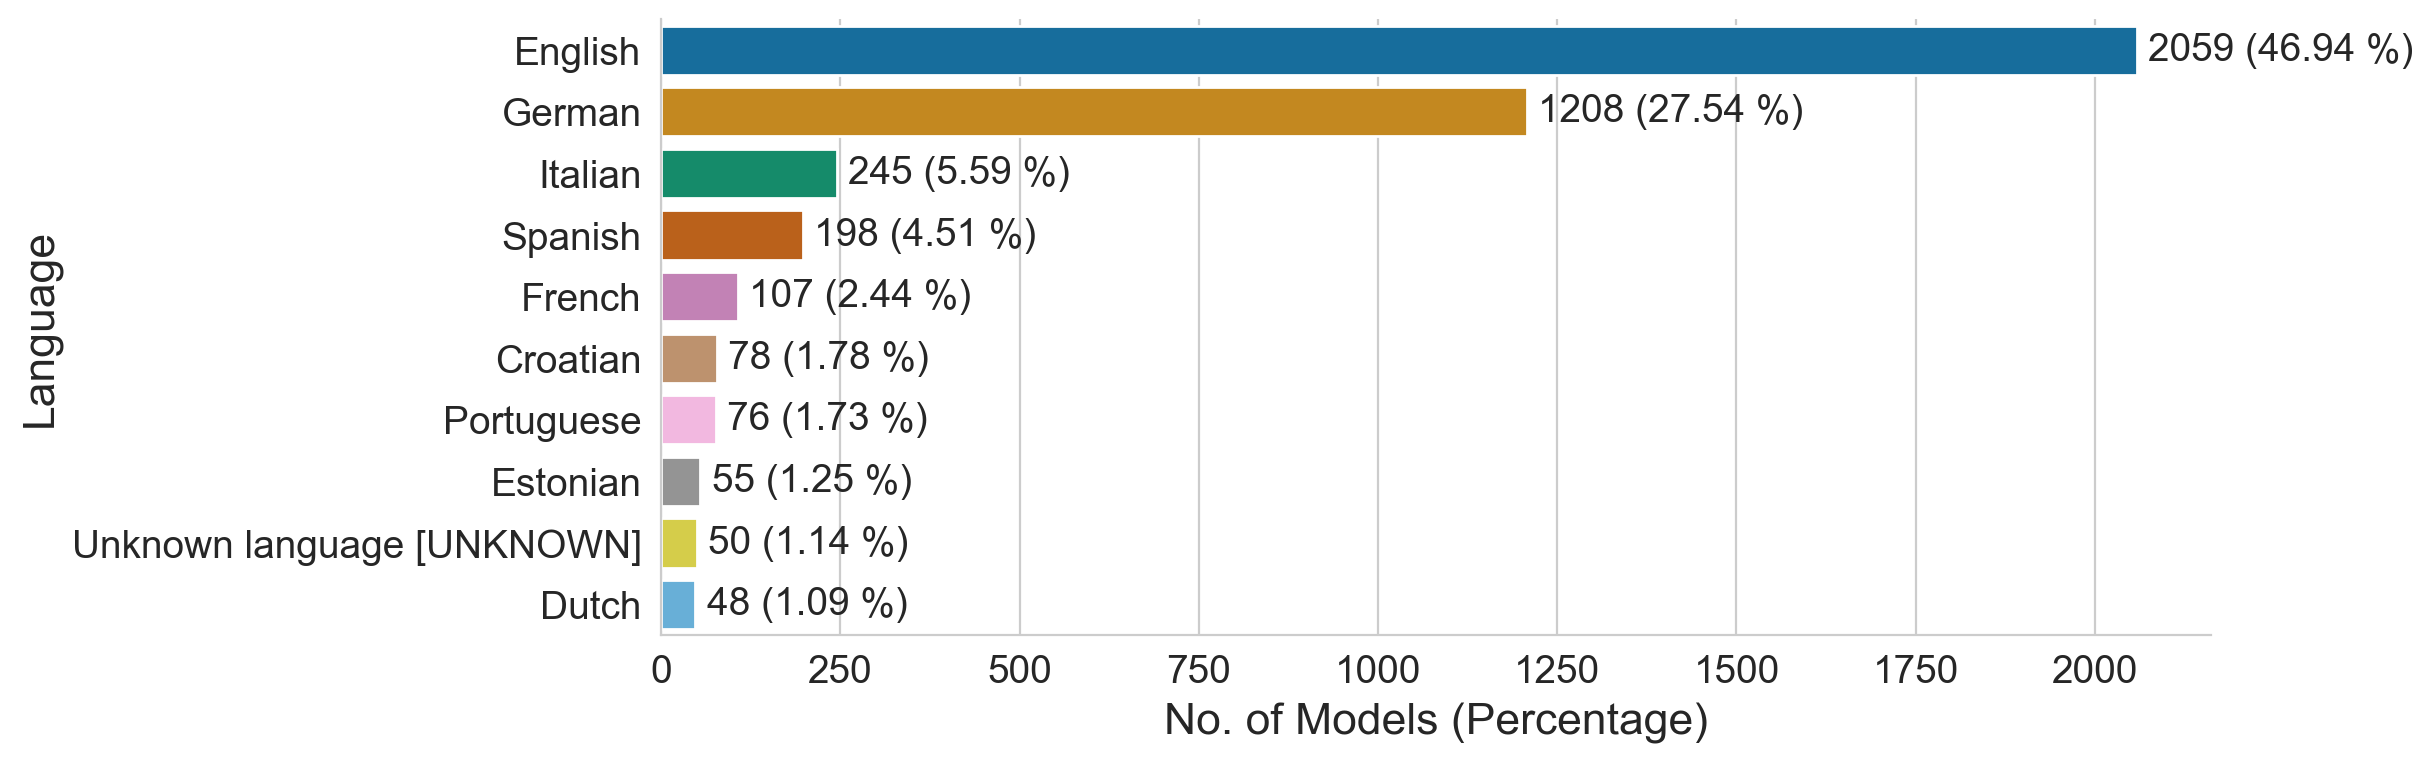

In [42]:
nr_most_common = 10
total = df_lang['No. of Models'].sum()
df_lang = df_lang.iloc[:10]
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
ax = sns.barplot(x="No. of Models", y="Language", data=df_lang,palette=sns.color_palette("colorblind"))
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_lang['No. of Models']])
ax.set_xlabel("No. of Models (Percentage)",fontsize=16)
ax.set_ylabel("Language",fontsize=16)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'languages.pdf',transparent=True,bbox_inches = 'tight')

# Element types 

Now we want to examine the usage of element types in the BPMN models.

In [43]:
def get_element_count(df_model):
    cnts = dict(Counter(df_model["category"].values))
    cnts["total_count"] = sum(cnts.values())
    return cnts

In [44]:
cnt_elements = pd.DataFrame.from_records(get_element_count(df_bpmn.loc[s]) for s in tqdm(df_bpmn.index.unique("model_id"))).fillna(0, downcast="infer") # comment this line if you have already created the pkl file
cnt_elements.to_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # comment this line if you have already created the pkl file
# cnt_elements = pd.read_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # uncomment this line if you have already created the pkl file
cnt_elements.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4386/4386 [00:01<00:00, 2295.79it/s]


Association_Undirected  DataObject  MessageFlow  \
0                      18          15           15   
1                       0          14            2   
2                       1           0            0   
3                       0           0            0   
4                       0           0            0   

   Association_Unidirectional  SequenceFlow  Pool  Lane  TextAnnotation  \
0                           9            69     6     8               5   
1                          14            61     1     3               0   
2                           0             4     1     1               1   
3                           0            29     0     0               0   
4                           0            24     1     3               0   

   IntermediateTimerEvent  ParallelGateway  Task  \
0                       3                8    22   
1                       0                0    32   
2                       1                0     2   
3                       0                2    16   
4                       1                0     8   

   IntermediateMessageEventThrowing  EndMessageEvent  \
0                                 8                3   
1                                 0                0   
2                                 0                0   
3                                 0                0   
4                                 0                0   

   IntermediateMessageEventCatching  CollapsedSubprocess  \
0                                 8                    8   
1                                 0                    0   
2                                 0                    0   
3                                 0                    0   
4                                 1                    1   

   StartConditionalEvent  EndNoneEvent  StartMessageEvent  \
0                      1             2                  3   
1                      0             3                  0   
2                      0             1                  0   
3                      0             1                  0   
4                      0             3                  1   

   Exclusive_Databased_Gateway  StartTimerEvent  total_count  StartNoneEvent  \
0                            1                1          213               0   
1                           11                0          144               3   
2                            0                0           13               1   
3                            4                0           55               1   
4                            5                0           52               0   

   InclusiveGateway  IntermediateLinkEventCatching  \
0                 0                              0   
1                 0                              0   
2                 0                              0   
3                 2                              0   
4                 0                              1   

   IntermediateLinkEventThrowing  EventbasedGateway  \
0                              0                  0   
1                              0                  0   
2                              0                  0   
3                              0                  0   
4                              1                  1   

   IntermediateConditionalEvent  DataStore  EndMultipleEvent  ITSystem  \
0                             0          0                 0         0   
1                             0          0                 0         0   
2                             0          0                 0         0   
3                             0          0                 0         0   
4                             1          0                 0         0   

   EndTerminateEvent  CollapsedPool  IntermediateSignalEventCatching  \
0                  0              0                                0   
1                  0              0                                0   
2                  0              0                

These are the statistics of the different element types per model:

In [45]:
# print(cnt_elements.columns)
# cnt_elements.drop(columns=["total_count","gdottedline","gdashedline","gtext","gellipse","gdiamond","grect"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()
cnt_elements.drop(columns=["total_count"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()

count    4386.000000
mean        9.976744
std         4.132901
min         1.000000
25%         7.000000
50%         9.000000
75%        13.000000
max        40.000000
dtype: float64

Thus, on average, a BPMN 2.0 model contains 11.3 different element types (median: 11).

We can also investigate the number of models that contain at least one instance of a particular element type. This gives us an indication of which element types are most important in practice.

In [46]:
df_cnts = (
    df_bpmn.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0, downcast="infer")
)
df_cnts.head()

category                          Association_Bidirectional  \
model_id                                                      
0c4a4701a6524166adaab25fb9e06374                          0   
0c4a6e19f392466c9f5ea34f0753397d                          0   
0c4a80580f0143c691ea5bbbb1f42ba1                          0   
0c4a8a87a5074bf0ac488fb15d9ff828                          0   
0c4aa1c91ff9451d89c2a6f69632e2ff                          0   

category                          Association_Undirected  \
model_id                                                   
0c4a4701a6524166adaab25fb9e06374                      18   
0c4a6e19f392466c9f5ea34f0753397d                       0   
0c4a80580f0143c691ea5bbbb1f42ba1                       1   
0c4a8a87a5074bf0ac488fb15d9ff828                       0   
0c4aa1c91ff9451d89c2a6f69632e2ff                       0   

category                          Association_Unidirectional  \
model_id                                                       
0c4a4701a6524166adaab25fb9e06374                           9   
0c4a6e19f392466c9f5ea34f0753397d                          14   
0c4a80580f0143c691ea5bbbb1f42ba1                           0   
0c4a8a87a5074bf0ac488fb15d9ff828                           0   
0c4aa1c91ff9451d89c2a6f69632e2ff                           0   

category                          CollapsedEventSubprocess  CollapsedPool  \
model_id                                                                    
0c4a4701a6524166adaab25fb9e06374                         0              0   
0c4a6e19f392466c9f5ea34f0753397d                         0              0   
0c4a80580f0143c691ea5bbbb1f42ba1                         0              0   
0c4a8a87a5074bf0ac488fb15d9ff828                         0              0   
0c4aa1c91ff9451d89c2a6f69632e2ff                         0              0   

category                          CollapsedSubprocess  CollapsedVerticalPool  \
model_id                                                                       
0c4a4701a6524166adaab25fb9e06374                    8                      0   
0c4a6e19f392466c9f5ea34f0753397d                    0                      0   
0c4a80580f0143c691ea5bbbb1f42ba1                    0                      0   
0c4a8a87a5074bf0ac488fb15d9ff828                    0                      0   
0c4aa1c91ff9451d89c2a6f69632e2ff                    1                      0   

category                          ComplexGateway  DataObject  DataStore  \
model_id                                                                  
0c4a4701a6524166adaab25fb9e06374               0          15          0   
0c4a6e19f392466c9f5ea34f0753397d               0          14          0   
0c4a80580f0143c691ea5bbbb1f42ba1               0           0          0   
0c4a8a87a5074bf0ac488fb15d9ff828               0           0          0   
0c4aa1c91ff9451d89c2a6f69632e2ff               0           0          0   

category                          EndCancelEvent  EndCompensationEvent  \
model_id                                                                 
0c4a4701a6524166adaab25fb9e06374               0                     0   
0c4a6e19f392466c9f5ea34f0753397d               0                     0   
0c4a80580f0143c691ea5bbbb1f42ba1               0                     0   
0c4a8a87a5074bf0ac488fb15d9ff828               0                     0   
0c4aa1c91ff9451d89c2a6f69632e2ff               0                     0   

category                          EndErrorEvent  EndEscalationEvent  \
model_id                                                              
0c4a4701a6524166adaab25fb9e06374              0                   0   
0c4a6e19f392466c9f5ea34f0753397d              0                   0   
0c4a80580f0143c691ea5bbbb1f42ba1              0                   0   
0c4a8a87a5074bf0ac488fb15d9ff828              0                   0   
0c4aa1c91ff9451d89c2a6f69632e2ff              0                   0   

category                          EndMessage

In [47]:
# df_cnts.drop(["gdashedline","gdiamond","gdottedline","gellipse","grect","gtext"],axis=1,inplace=True)

In [48]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    #.div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("frequency")
    .reset_index()
    .rename(columns={"index":"category"})
)
len(df_freq[df_freq["frequency"]/len(df_cnts) < 0.1])

42

In [49]:
df_freq = df_freq[df_freq["frequency"]/len(df_cnts) >= 0.1]
from stringcase import sentencecase
df_freq["category"] = df_freq["category"].apply(lambda x: sentencecase(x)).replace({"I t system": "IT system"})
df_freq["category"] = df_freq["category"].apply(lambda x: x.strip())
df_freq.head()

category  frequency
0                  Sequence flow       4302
1                           Task       4245
2                 End none event       3846
3               Start none event       3344
4  Exclusive  databased  gateway       3266

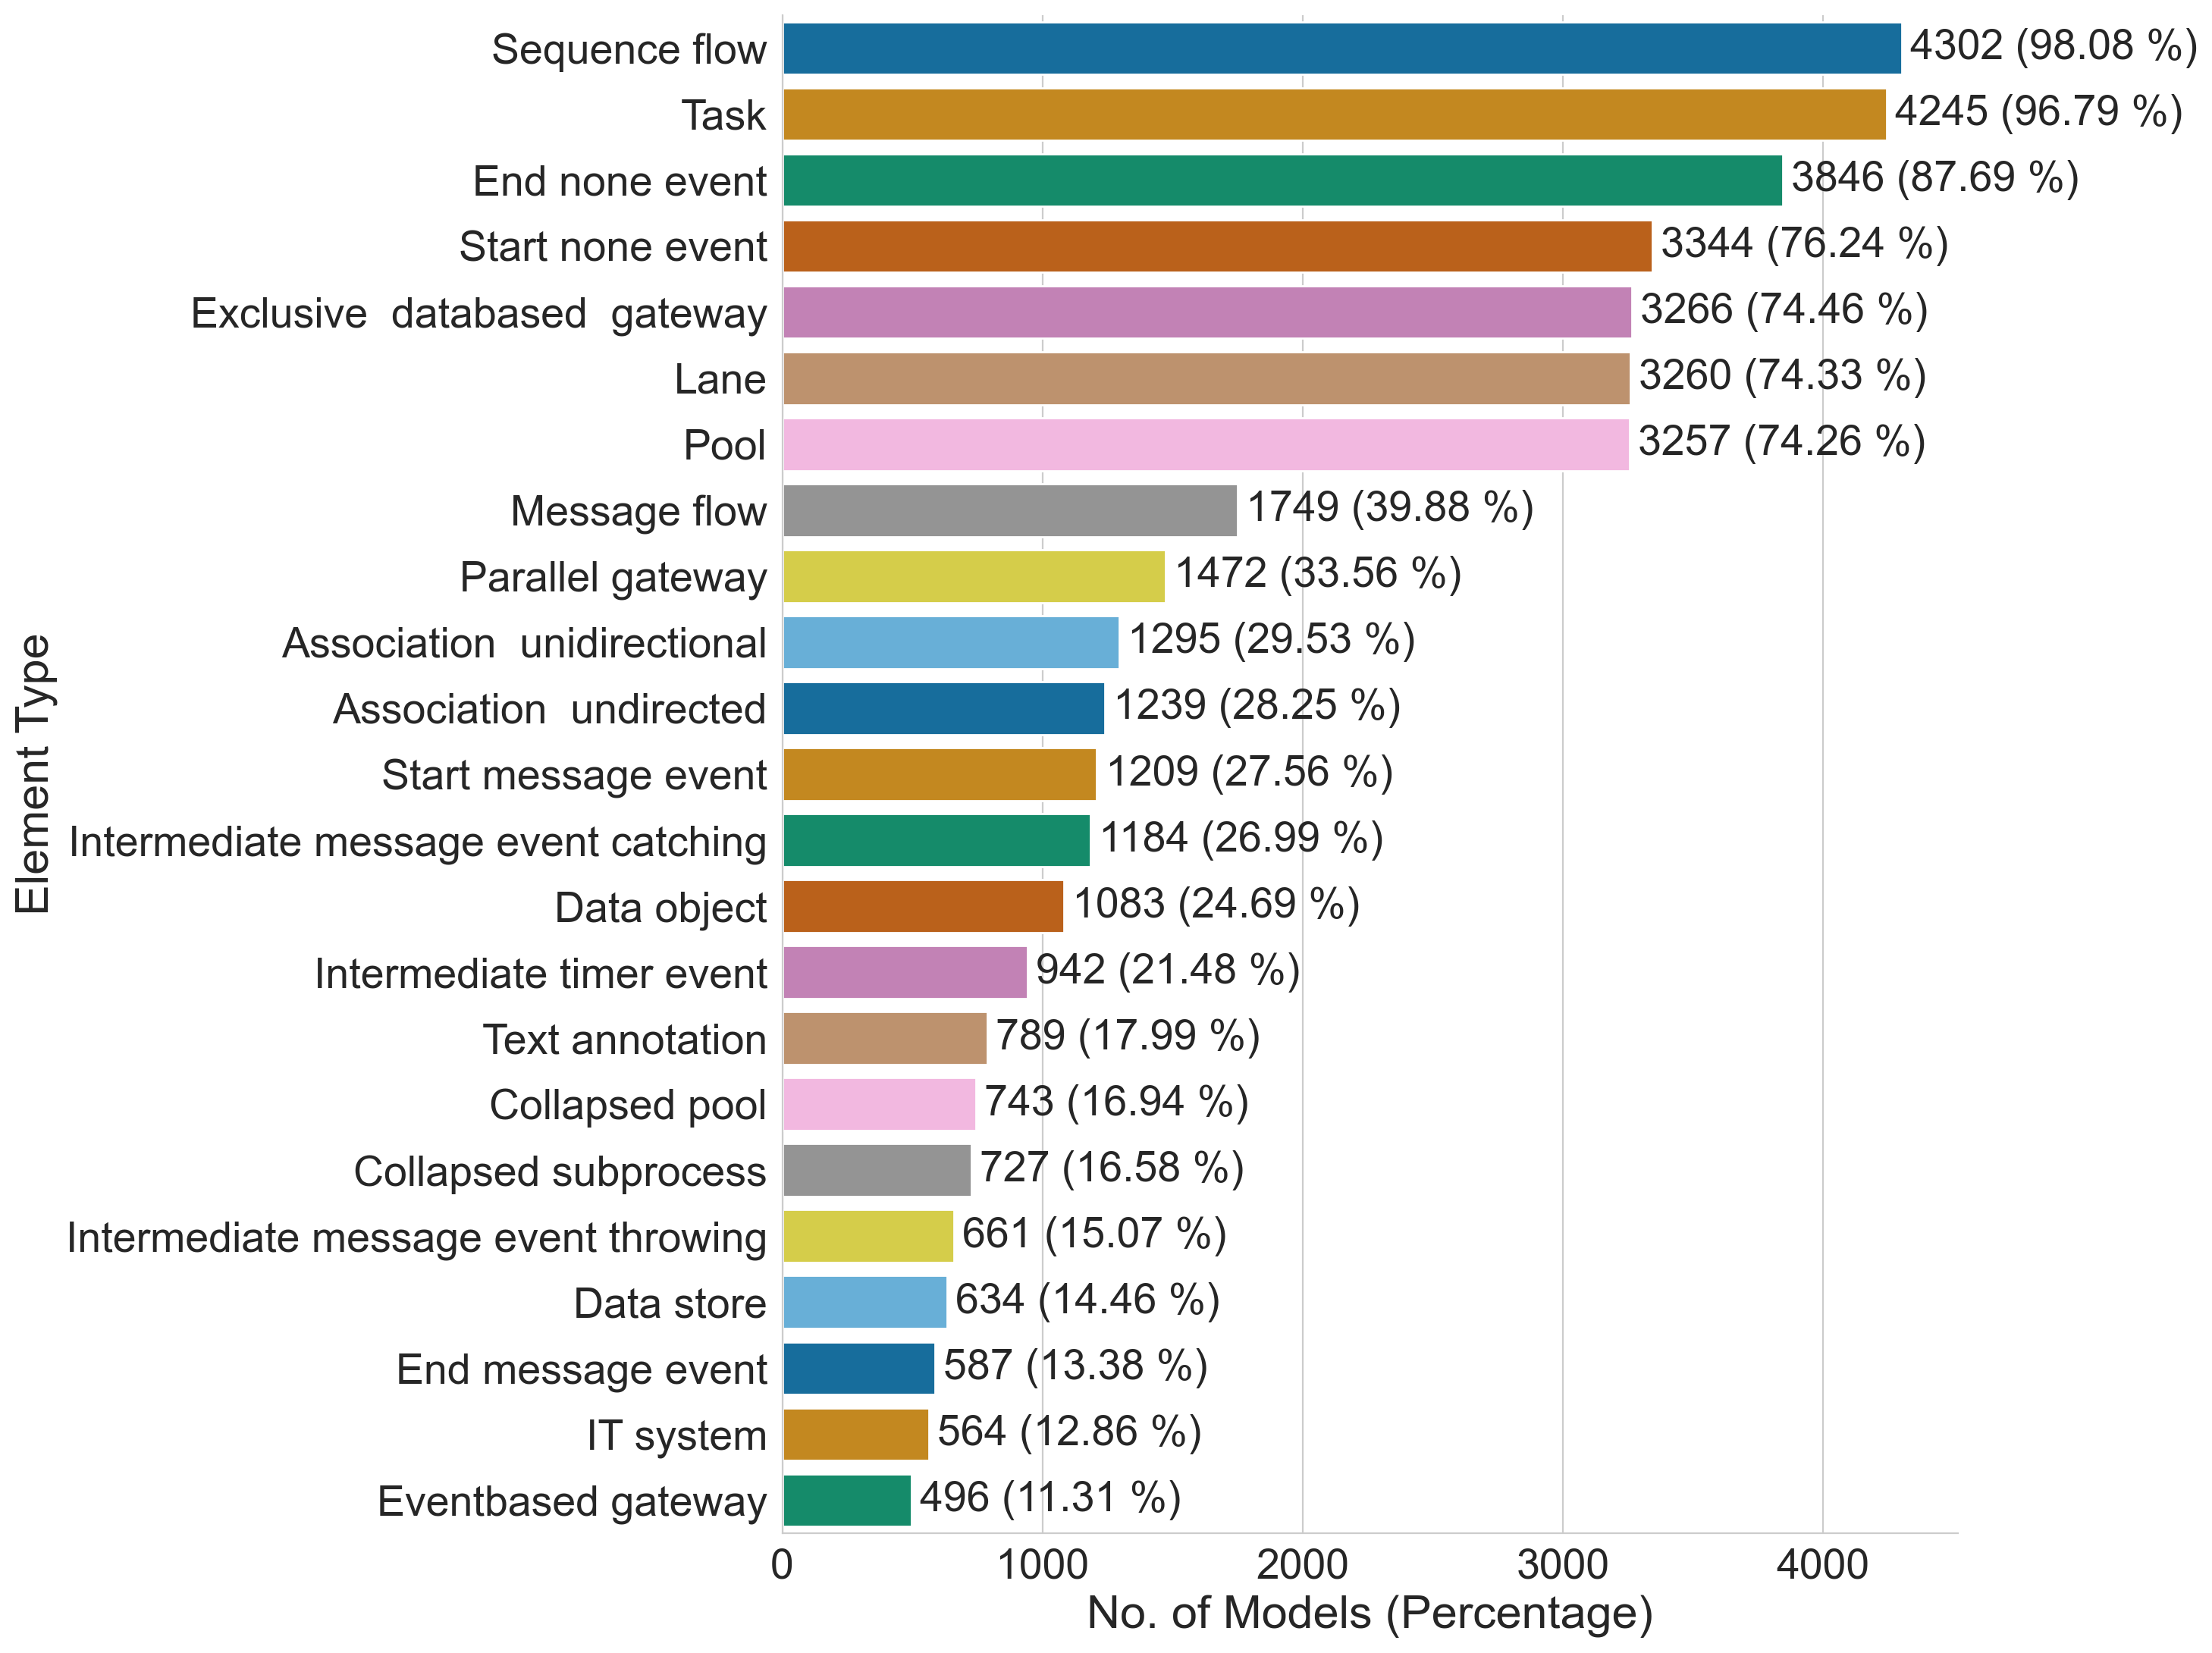

In [50]:
plt.figure(figsize=(10,13)) # 10,13
plt.rcParams.update({'font.size': 20}) # 22
ax = sns.barplot(x="frequency", y="category", data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind"));
total = len(df_cnts)
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_freq['frequency']])
sns.despine()
ax.set_xlabel("No. of Models (Percentage)",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'elements_usage.pdf',transparent=True,bbox_inches = 'tight')

# Elements

These are the statistics of the number of elements per model:

In [51]:
cnt_elements.total_count.describe()

count    4386.000000
mean       50.061788
std        47.232461
min         1.000000
25%        22.000000
50%        39.000000
75%        63.000000
max       946.000000
Name: total_count, dtype: float64

These are the statistics of the number of elements per model by element type:

In [52]:
cnt_elements.describe().transpose()

count       mean        std  min  \
Association_Undirected                     4386.0   1.242818   4.830311  0.0   
DataObject                                 4386.0   0.972184   3.483226  0.0   
MessageFlow                                4386.0   1.963292   3.683644  0.0   
Association_Unidirectional                 4386.0   1.552896   4.559057  0.0   
SequenceFlow                               4386.0  19.708162  18.248309  0.0   
Pool                                       4386.0   1.166895   1.066311  0.0   
Lane                                       4386.0   2.124031   2.035967  0.0   
TextAnnotation                             4386.0   0.614911   4.018673  0.0   
IntermediateTimerEvent                     4386.0   0.391473   0.988052  0.0   
ParallelGateway                            4386.0   0.861377   1.687415  0.0   
Task                                       4386.0   9.424761   8.905147  0.0   
IntermediateMessageEventThrowing           4386.0   0.420429   1.390203  0.0   
EndMessageEvent                            4386.0   0.238942   0.790131  0.0   
IntermediateMessageEventCatching           4386.0   0.755814   1.889265  0.0   
CollapsedSubprocess                        4386.0   0.385773   1.190544  0.0   
StartConditionalEvent                      4386.0   0.018924   0.152089  0.0   
EndNoneEvent                               4386.0   1.738714   1.685444  0.0   
StartMessageEvent                          4386.0   0.411765   0.995813  0.0   
Exclusive_Databased_Gateway                4386.0   2.913589   4.041186  0.0   
StartTimerEvent                            4386.0   0.080255   0.342953  0.0   
total_count                                4386.0  50.061788  47.232461  1.0   
StartNoneEvent                             4386.0   0.922253   0.799442  0.0   
InclusiveGateway                           4386.0   0.154811   0.621889  0.0   
IntermediateLinkEventCatching              4386.0   0.018012   0.170570  0.0   
IntermediateLinkEventThrowing              4386.0   0.017328   0.163124  0.0   
EventbasedGateway                          4386.0   0.166211   0.569829  0.0   
IntermediateConditionalEvent               4386.0   0.035796   0.325776  0.0   
DataStore                                  4386.0   0.316461   1.161404  0.0   
EndMultipleEvent                           4386.0   0.000684   0.026147  0.0   
ITSystem                                   4386.0   0.398769   1.694552  0.0   
EndTerminateEvent                          4386.0   0.101231   0.491444  0.0   
CollapsedPool                              4386.0   0.259006   0.685369  0.0   
IntermediateSignalEventCatching            4386.0   0.017328   0.193794  0.0   
IntermediateSignalEventThrowing            4386.0   0.009804   0.175187  0.0   
processparticipant                         4386.0   0.054036   0.588021  0.0   
Subprocess                                 4386.0   0.113543   0.509310  0.0   
Message                                    4386.0   0.083219   0.643647  0.0   
EndEscalationEvent                         4386.0   0.007296   0.097595  0.0   
Association_Bidirectional                  4386.0   0.038532   0.376168  0.0   
IntermediateEvent                          4386.0   0.067487   0.554452  0.0   
EndErrorEvent                              4386.0   0.036708   0.231543  0.0   
IntermediateCancelEvent                    4386.0   0.007068   0.094042  0.0   
IntermediateErrorEvent                     4386.0   0.067259   0.372106  0.0   
EventSubprocess                            4386.0   0.023484   0.231293  0.0   
StartSignalEvent                           4386.0   0.008664   0.139776  0.0   
EndCancelEvent                             4386.0   0.017100   0.175927  0.0   
StartEscalationEvent                       4386.0   0.001824   0.042674  0.0   
IntermediateEscalationEventThrowing        4386.0   0.003876   0.081231  0.0   
Group                                      4386.0   0.022344   0.300441  0.0   
VerticalPool                               4

The above table is quite large, therefore we summarize it by aggregating the element types to groups and categories as given by the Signavio BPMN 2.0 stencil set specification.

In [53]:
d_low_level_mapping = mappings["element_type_low_level"] # groups
d_high_level_mapping = mappings["element_type_high_level"] # categories

Let's first have a look at the lower level aggregation (groups of similar element types):

In [54]:
df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()
df_stats = df_low_level.describe().transpose()
df_stats.head()

count       mean        std  min   25%   50%   75%    max
Activities          4386.0   9.952804   9.108909  0.0   4.0   8.0  12.0  135.0
Artifacts           4386.0   1.036024   4.468675  0.0   0.0   0.0   1.0  157.0
Connecting Objects  4386.0  24.505700  24.836158  0.0  10.0  18.0  31.0  507.0
Data Elements       4386.0   1.371865   3.985850  0.0   0.0   0.0   1.0   98.0
Events              4386.0   5.455084   5.865767  0.0   2.0   3.0   6.0   93.0

In [55]:
df_stats.drop(columns=["count"],inplace=True)
df_stats = df_stats.round(1)
df_stats

mean   std  min   25%   50%   75%    max
Activities          10.0   9.1  0.0   4.0   8.0  12.0  135.0
Artifacts            1.0   4.5  0.0   0.0   0.0   1.0  157.0
Connecting Objects  24.5  24.8  0.0  10.0  18.0  31.0  507.0
Data Elements        1.4   4.0  0.0   0.0   0.0   1.0   98.0
Events               5.5   5.9  0.0   2.0   3.0   6.0   93.0
Gateways             4.1   5.1  0.0   1.0   3.0   6.0  122.0
Swimlanes            3.6   3.1  0.0   2.0   4.0   5.0   32.0

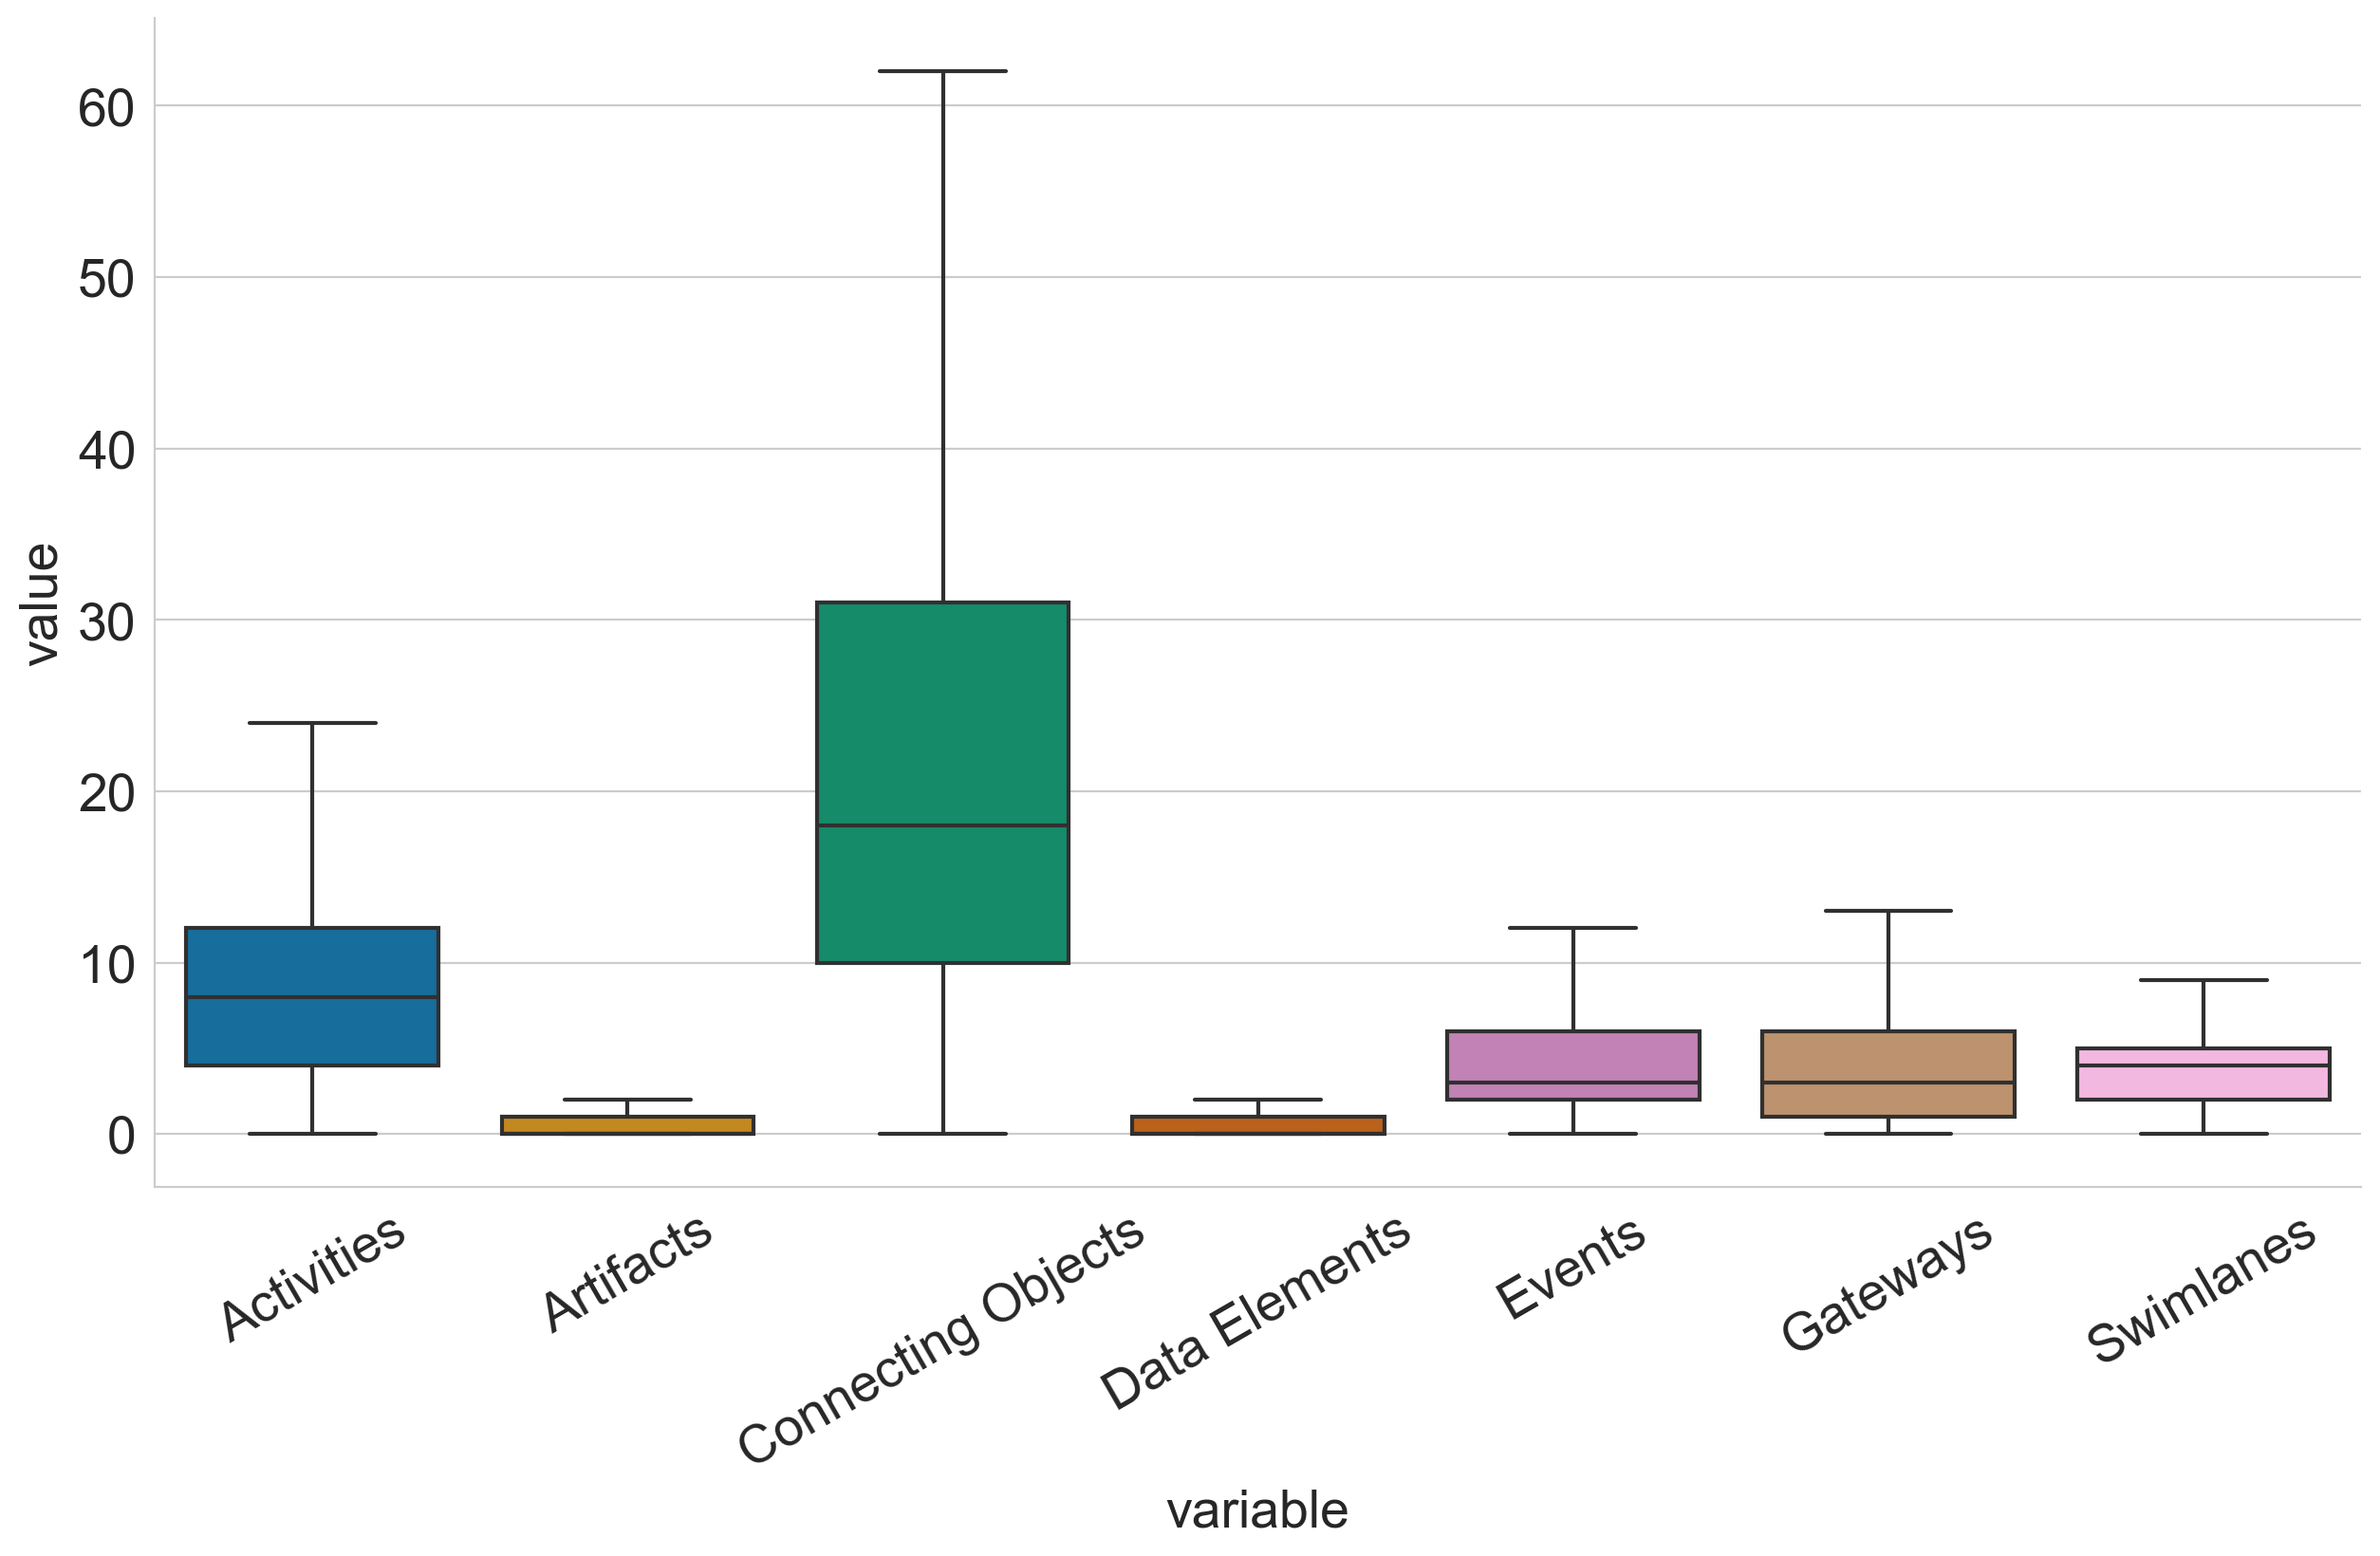

In [56]:
plt.figure(figsize=(15,8))
df_low_level["id"] = df_low_level.index
df_low_level_long = pd.melt(df_low_level, id_vars='id', value_vars=['Activities', 'Artifacts', 'Connecting Objects', 'Data Elements', 'Events', 'Gateways', 'Swimlanes'])
ax=sns.boxplot(x="variable", y="value", data=df_low_level_long,showfliers=False,palette=sns.color_palette("colorblind"))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.despine()

Now, let's also have a look at a higher level aggregation (categories: nodes and edges).

In [57]:
df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()
df_high_level.rename(columns={"edge": "No. of Edges", "node": "No. of Nodes"},inplace=True)
df_high_level.describe().transpose()

count       mean        std  min   25%   50%   75%    max
No. of Edges  4386.0  24.505700  24.836158  0.0  10.0  18.0  31.0  507.0
No. of Nodes  4386.0  25.556088  22.630262  1.0  12.0  20.0  32.0  439.0

In [58]:
df_high_level.head()

No. of Edges  No. of Nodes
0           111           102
1            77            67
2             5             8
3            29            26
4            24            28

The number of nodes and edges is naturally highly correlated:

<Figure size 500x500 with 0 Axes>

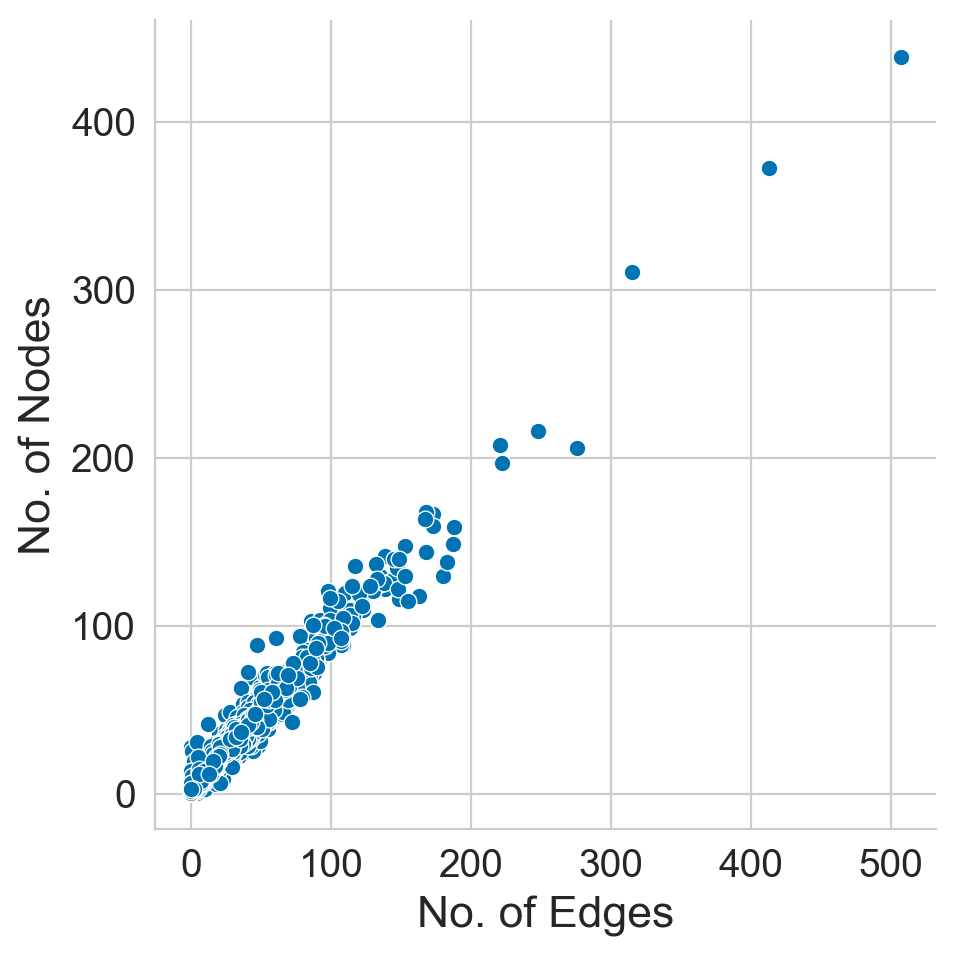

In [59]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14,'axes.labelsize': 16})
ax = sns.relplot(data=df_high_level.astype(float), x = "No. of Edges", y = "No. of Nodes",color=sns.color_palette("colorblind",as_cmap=True)[0])
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'correl_plot.png',transparent=True,bbox_inches = 'tight',dpi=300)

# Process names 

Let's now have a look at the process names.

A function for cleaning the names or labels (if required for the use case):

In [60]:
def clean(label):
    # handle some special cases
    label = label.replace("\n", " ").replace("\r", "")
    label = label.replace("(s)", "s")
    # turn any non alphanumeric characters into whitespace
    # label = re.sub("[^A-Za-z]"," ",label)
    # delete unnecessary whitespaces
    label = label.strip()
    label = re.sub("\s{1,}"," ",label)
    # make all lower case
    label = label.lower()
    return label

def alphanumeric(label):
    return re.sub("[^A-Za-z]"," ",label)

In [61]:
cnts_names = dict(Counter(df_meta['name'].values))
#cnts_names = dict(Counter(df_meta['name'].apply(lambda x: clean(str(x))).values))
cnts_names = pd.DataFrame.from_dict(cnts_names.items())
cnts_names.columns = ['name', 'occurrences']
cnts_names = cnts_names.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_names.head(10)

name  occurrences
0         12345678          269
1      New Process          137
2    Neuer Prozess           52
3    12345678_rev1           30
4         Jane Doe           22
5    12345678_rev2           19
6    12345678_rev3           13
7      New Diagram           12
8  New UML Diagram           11
9    12345678_rev4           11

The number of distinct process names:

In [62]:
len(cnts_names)

5232

We use Signavio's color palette for the word cloud.

In [63]:
import random
colors = constants.COLORS_SIGNAVIO_HSL 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

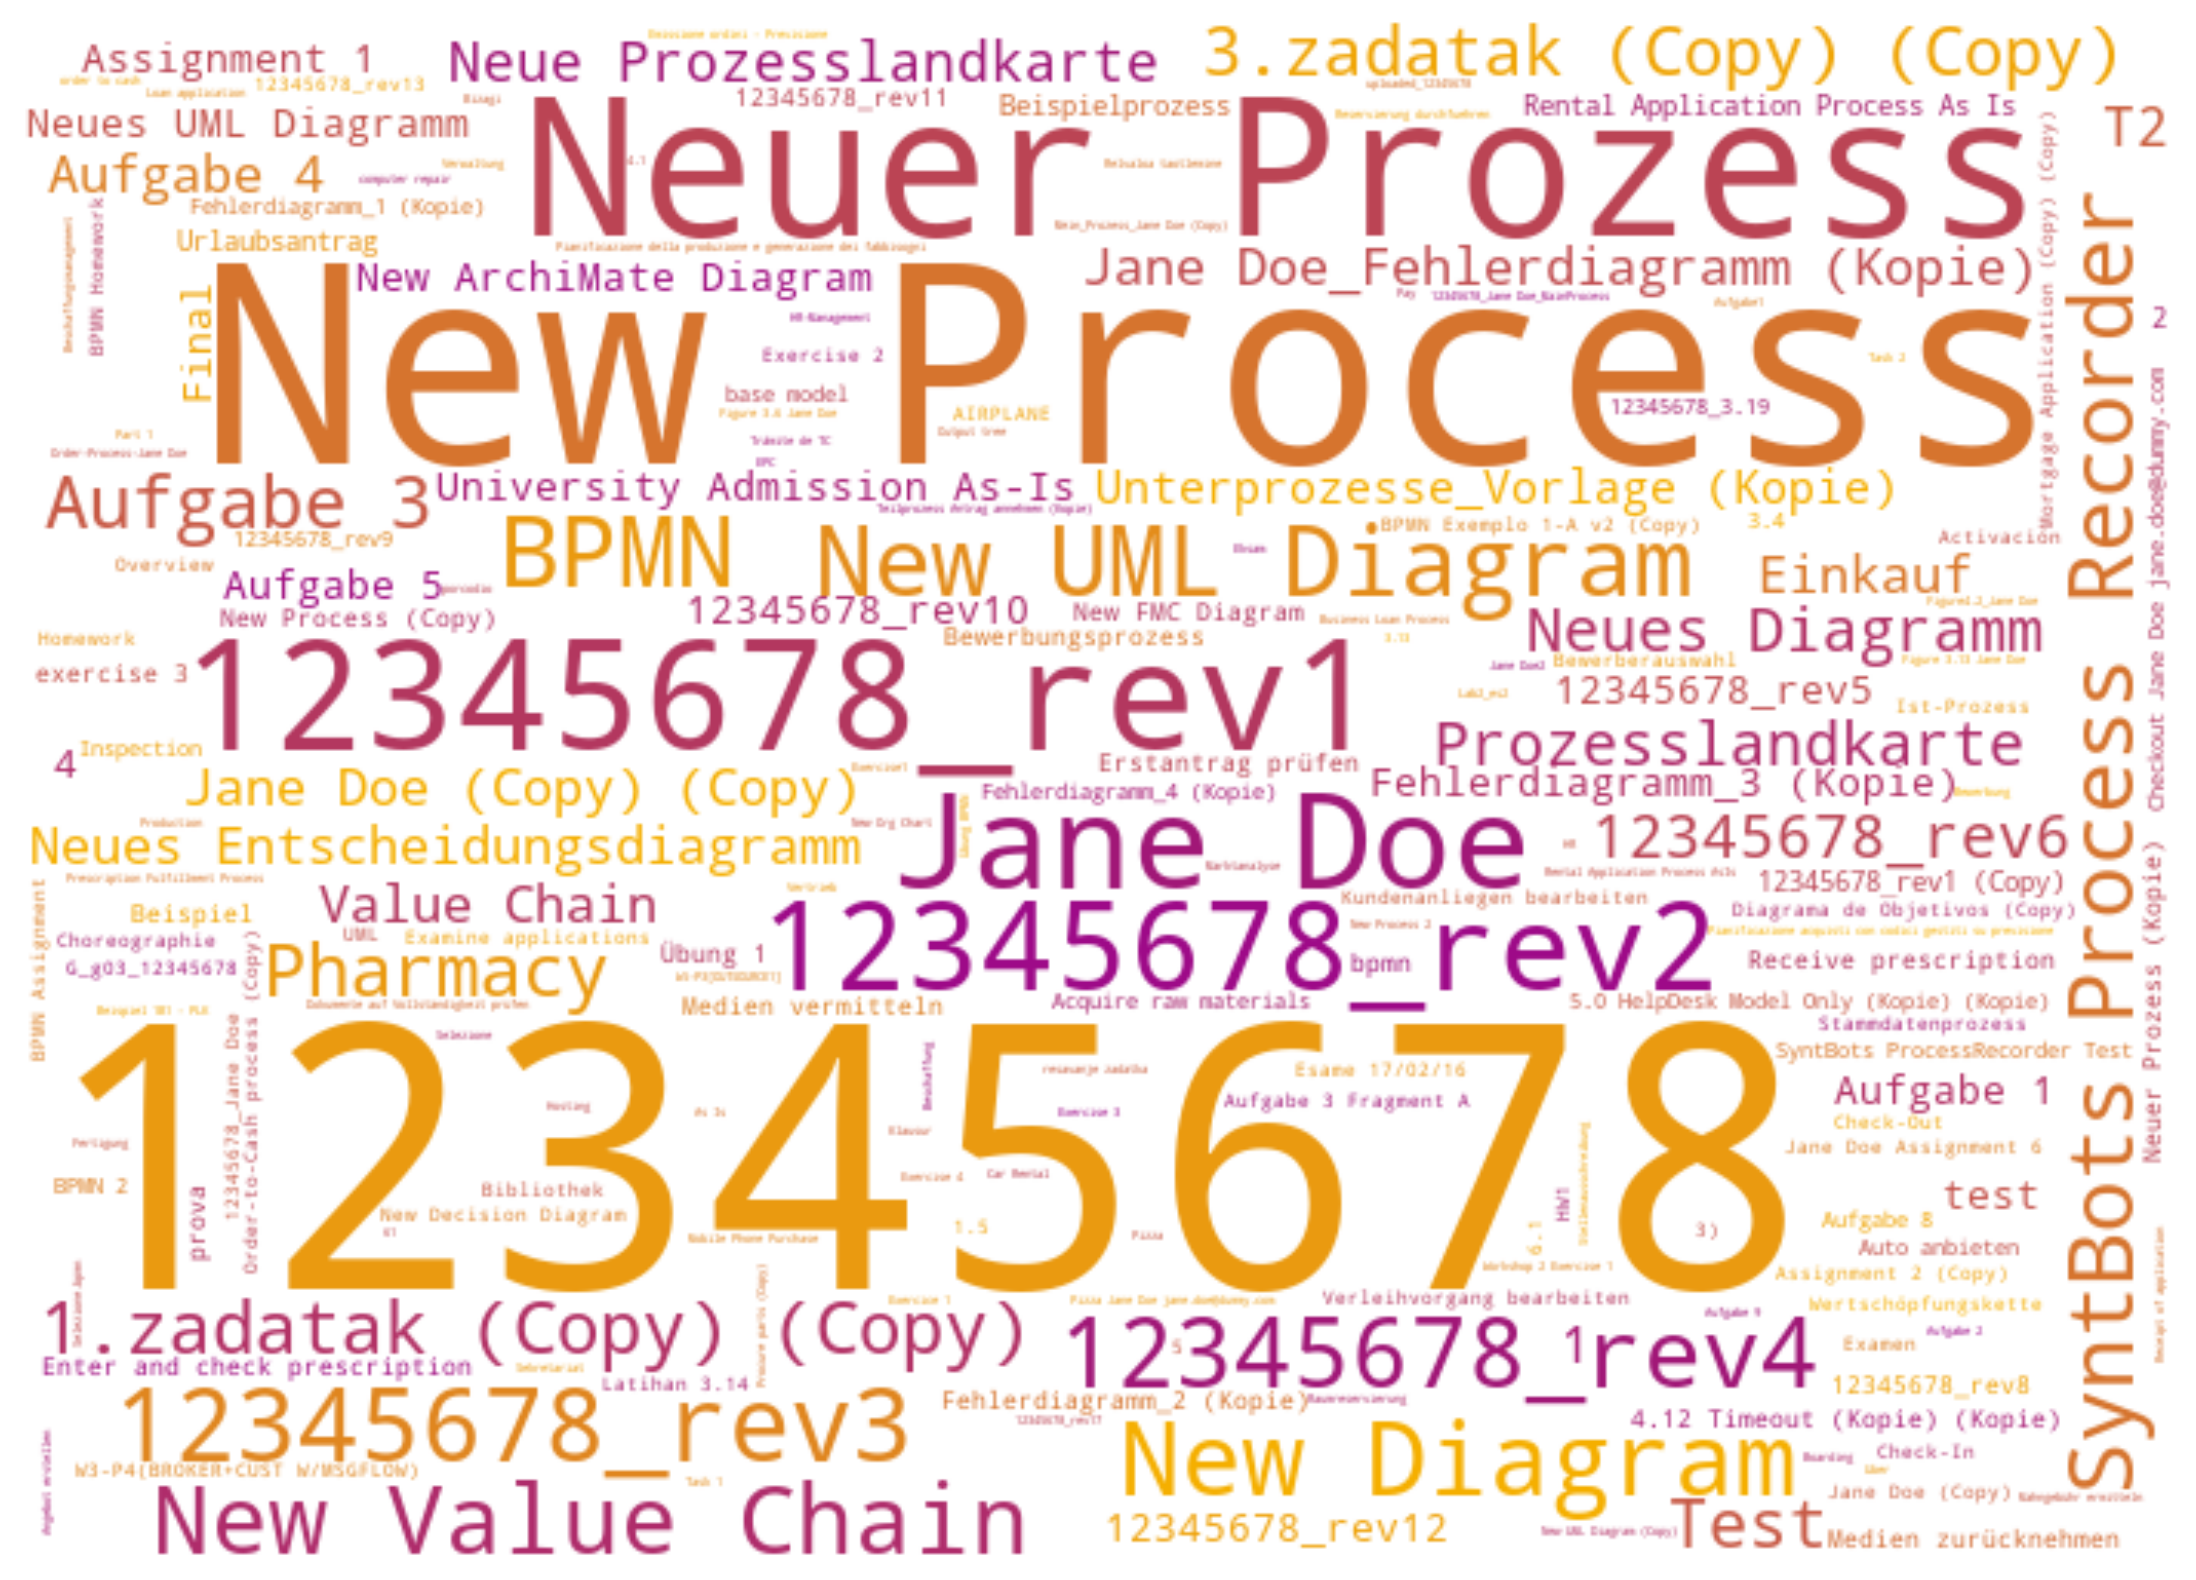

In [64]:
wordcloud_dict_names = dict(zip(cnts_names.name, cnts_names.occurrences))
wordcloud = WordCloud(min_word_length=1,background_color='white',width=700, height=500)
wordcloud = wordcloud.generate_from_frequencies(wordcloud_dict_names)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_process_names.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

It seems like the word cloud is dominated by the process names of the examples processes that are added to each newly created workspace.

# Labels

Let's also investigate element labels.

In [65]:
# cnts_labels = dict(Counter(df_bpmn['label'].apply(lambda x: clean(str(x))).values))
cnts_labels = dict(Counter(df_bpmn['label'].values))
cnts_labels = pd.DataFrame.from_dict(cnts_labels.items())
cnts_labels.columns = ['label', 'occurrences']
cnts_labels = cnts_labels.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_labels = cnts_labels[~cnts_labels.label.isin([None,""])]
cnts_labels.reset_index(drop=True, inplace=True)
cnts_labels.head(10)

label  occurrences
0        No         1248
1       Yes          996
2        Ja          646
3      Nein          617
4        no          491
5      nein          439
6        ja          425
7       yes          399
8        NO          271
9  Customer          255

The number of distinct element labels:

In [66]:
len(cnts_labels)

70871

2.820.531 labels are used for the 28.293.762 elements in the BPMN models:

In [67]:
len(df_bpmn)

219571

10 % of the unique labels make up for more than 74.0 % of the element labels ...

In [68]:
sum(cnts_labels.occurrences[:int(len(cnts_labels)*0.1)])/sum(cnts_labels.occurrences)

0.36080331070758637

... while 64.9 % of the labels are used for only one element.

In [69]:
len(cnts_labels[cnts_labels.occurrences==1])/len(cnts_labels)

0.867223547007944

In [70]:
len(cnts_labels[cnts_labels.occurrences==1])

61461

Let's visualize the distribution of the label usage frequency in BPMN 2.0 models.

In [71]:
bins = cnts_labels
bins.head()

label  occurrences
0    No         1248
1   Yes          996
2    Ja          646
3  Nein          617
4    no          491

We sort the labels based on their absolute usage frequency in descending order and group them in bins of size 10,000 to visualize the unevenness of the distribution.

In [72]:
N = 10000
bins = bins.groupby(bins.index // N).sum()

In [73]:
import math

bins["bins of labels"] = [N*i for i in range(1,math.ceil(len(cnts_labels)/N)+1)]
bins.head()

occurrences  bins of labels
0        42551           10000
1        10000           20000
2        10000           30000
3        10000           40000
4        10000           50000

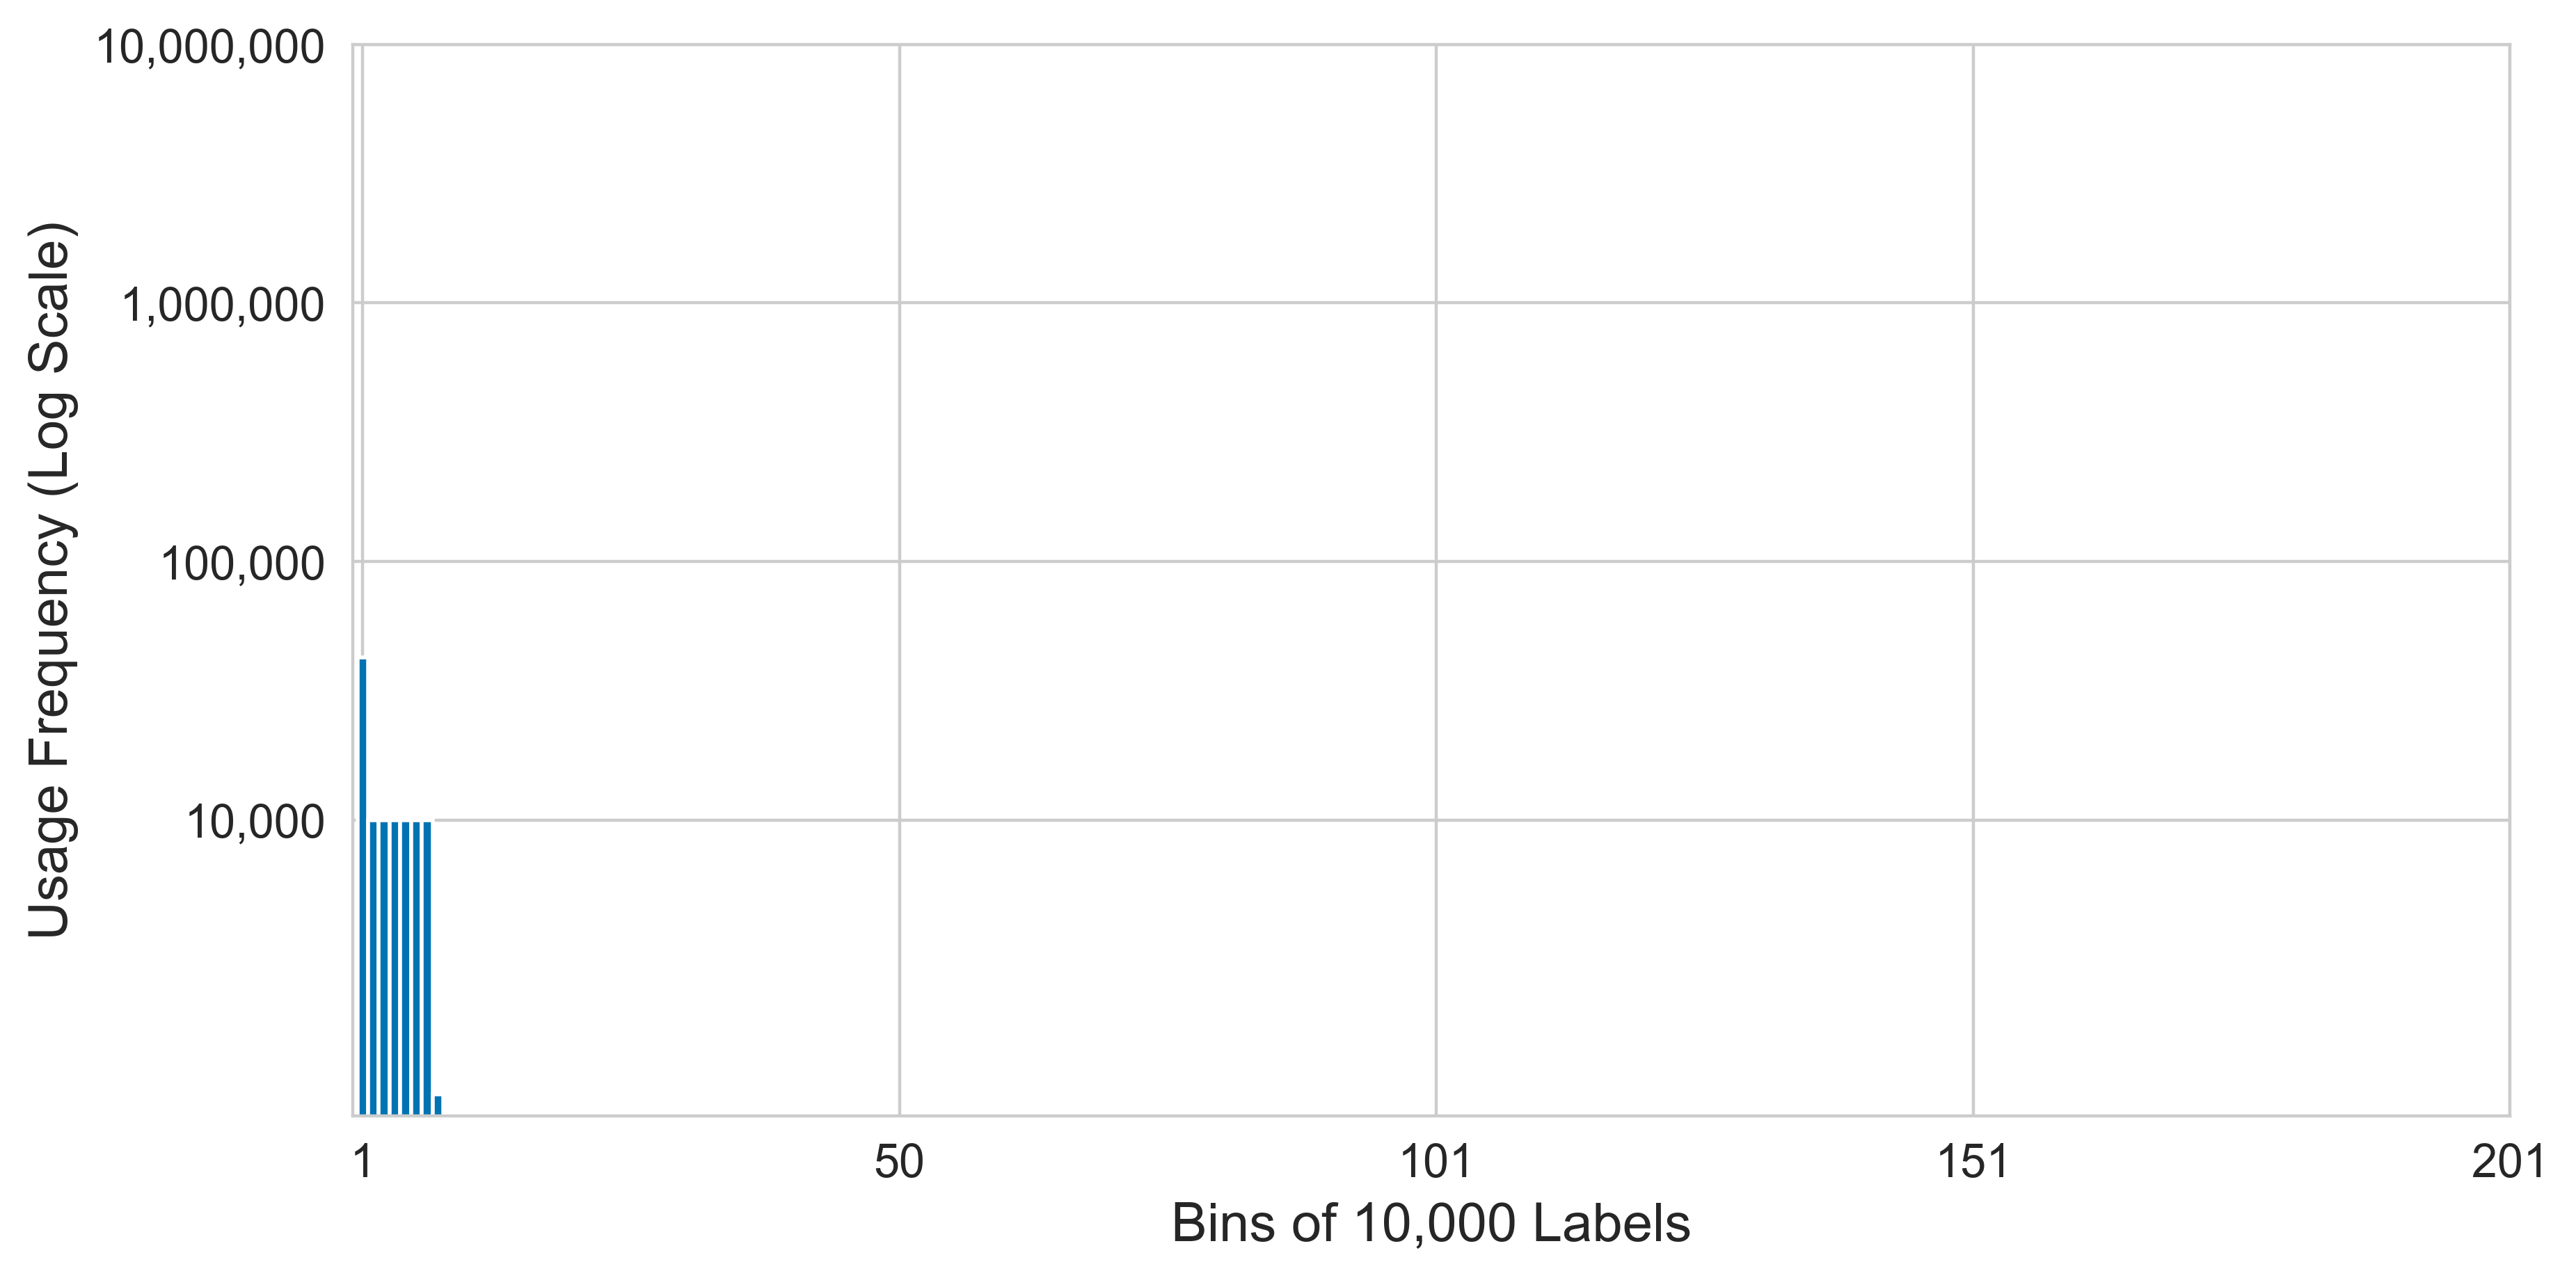

In [74]:
nb_of_bins = len(bins)
plt.figure(figsize=(10,5),dpi=200)
plt.rcParams.update({'font.size': 12,'axes.labelsize': 14})
ax=plt.bar([i for i in range(0,nb_of_bins)],height=list(bins["occurrences"]),width=1,color=sns.color_palette("colorblind",as_cmap=True)[0])
plt.yscale('log')
plt.xticks([0,50,100,150,200], ["1","50","101","151","201"])
plt.yticks(np.array([1.e+04, 1.e+05, 1.e+06, 1.e+07]),["10,000","100,000","1,000,000","10,000,000"])
plt.xlabel("Bins of 10,000 Labels")
plt.ylabel("Usage Frequency (Log Scale)")
plt.savefig(constants.FIGURES_ROOT / 'labels_usage.pdf',transparent=True,bbox_inches = 'tight')

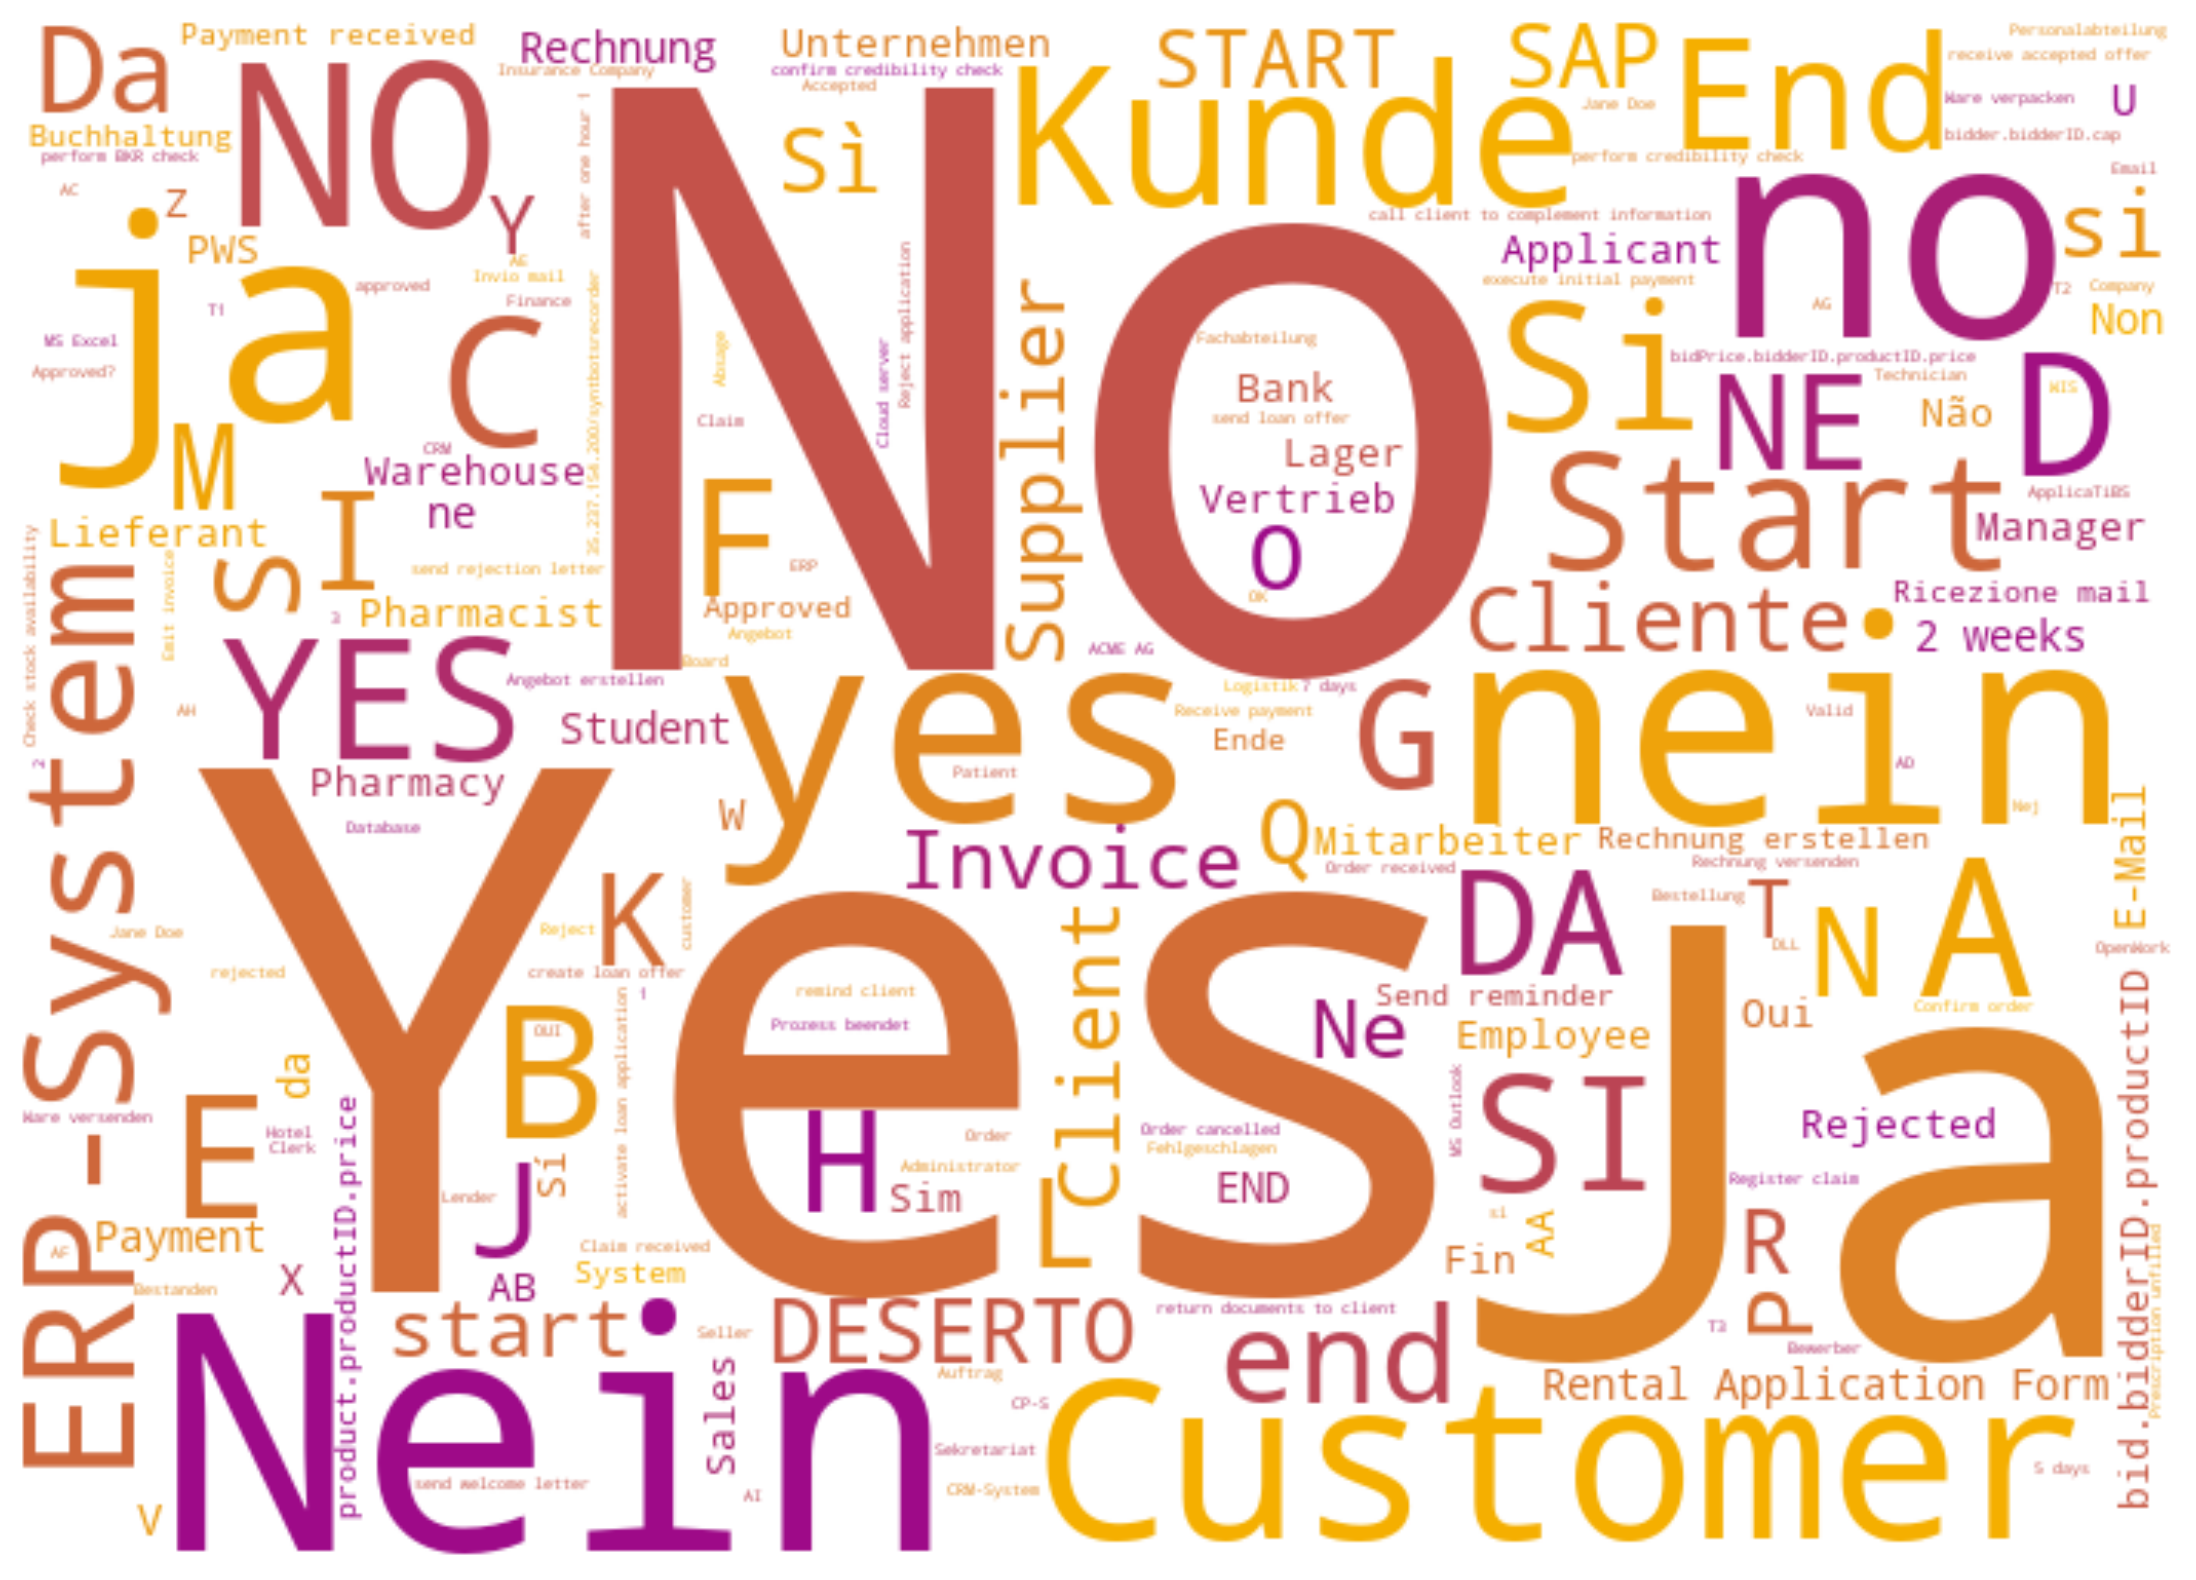

In [75]:
wordcloud_dict_labels = dict(zip(cnts_labels.label, cnts_labels.occurrences))
wordcloud_dict_labels = {k: v for k, v in wordcloud_dict_labels.items() if '\n' not in k}
wordcloud = WordCloud(min_word_length=2,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_labels)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_labels.pdf',transparent=True,bbox_inches = 'tight')
plt.show()